#### Imports & Settings

In [101]:
# === Libraries ===
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import librosa
import pandas as pd
from scipy.signal import savgol_filter

plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (15, 5)

print("Imports loaded.")


Imports loaded.


#### Files handling

In [102]:
participants = ["emre", "olena", "narmeen", "sneha", "paula", "yernur", "peyman"]
conditions = ["normal", "fatigue", "cough"]

def get_file(p, cond):
    return f"{p}_{cond}.wav"

def load_audio(path, sr=16000):
    y, sr = librosa.load(path, sr=sr)
    y = librosa.util.normalize(y)
    return y, sr



#### Extract breathing envelop

In [104]:
def extract_breathing_envelope(y, sr, target_sr=100):
    # Normalize
    y = y / (np.max(np.abs(y)) + 1e-12)

    # Hilbert envelope
    analytic = signal.hilbert(y)
    env = np.abs(analytic)

    # Smooth
    env = savgol_filter(env, 201, 3)

    # Light low-pass below ~0.7 Hz (breathing band)
    b, a = signal.butter(1, 0.7 / (sr/2), btype='low')
    env = signal.filtfilt(b, a, env)

    # Z-score
    env = (env - np.mean(env)) / (np.std(env) + 1e-12)

    # Downsample
    N = int(len(env) * target_sr / sr)
    env = signal.resample(env, N)

    return env, target_sr


#### Peak-based breathing detection

In [105]:
def detect_breath_peaks(env, sr_env):
    d = np.gradient(env)
    d = signal.medfilt(d, kernel_size=101)

    # zero crossings from + to -
    zc = np.where(np.diff(np.sign(d)) < 0)[0]

    # minimum separation = 0.8 seconds
    min_dist = int(0.8 * sr_env)

    peaks = []
    last = -9999
    for z in zc:
        if z - last >= min_dist:
            peaks.append(z)
            last = z

    peaks = np.array(peaks)

    # BPM
    if len(peaks) < 2:
        bpm = 0
    else:
        intervals = np.diff(peaks) / sr_env
        bpm = 60 / np.mean(intervals)

    brv = compute_brv_from_peaks(peaks, sr_env)
    return peaks, bpm, brv


#### BRV

In [106]:
def compute_brv_from_peaks(peaks, sr_env):
    if len(peaks) < 3:
        return {"sdnn":0, "rmssd":0, "cv":0, "mean_ibi":0}

    times = peaks / sr_env
    ibis = np.diff(times)

    if len(ibis) < 2:
        return {"sdnn":0, "rmssd":0, "cv":0, "mean_ibi":np.mean(ibis)}

    sdnn = np.std(ibis)
    rmssd = np.sqrt(np.mean(np.diff(ibis)**2))
    cv = sdnn / np.mean(ibis)

    return {"sdnn": sdnn, "rmssd": rmssd, "cv": cv, "mean_ibi": np.mean(ibis)}


#### Classify

In [113]:
def classify_breathing(bpm, brv_sdnn, brv_rmssd, brv_cv, n_breaths):
    """
    Robust classifier for fatigue vs normal breathing.
    Uses BPM primarily, BRV as refinement.
    """

    # --- 1. STRONG RULES BASED ON BPM ONLY ---
    if bpm < 14:
        return "normal"
    if bpm > 22:
        return "fatigue"


    # Normal breathing shows more variability
    brv_score = (brv_sdnn + brv_rmssd + brv_cv)

    if brv_score > 0.52:
        return "normal"
    else:
        return "fatigue"


#### plots

In [116]:
def plot_raw_with_breaths(y, sr, breath_peaks_env, env_len, sr_env, title="Raw Signal"):
    t = np.arange(len(y)) / sr
    env_times = breath_peaks_env / sr_env

    plt.figure(figsize=(18,4))
    plt.plot(t, y, color="orange", label="Raw Audio")

    plt.scatter(env_times,
                np.zeros_like(env_times),
                c="green", s=80, label="Breaths")

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.legend()
    plt.show()

def plot_envelope_with_breaths(env, sr_env, breath_peaks, bpm, title="Breathing Envelope"):
    t = np.arange(len(env)) / sr_env

    plt.figure(figsize=(16,4))
    plt.plot(t, env, color="orange", label="Breathing Envelope")

    # Plot breath peaks
    plt.scatter(breath_peaks / sr_env, env[breath_peaks],
                s=80, c="green", label="Breaths")

    plt.text(0.01, 0.95,
             f"BPM: {bpm:.1f}",
             transform=plt.gca().transAxes,
             fontsize=14,
             bbox=dict(facecolor="white", alpha=0.7, edgecolor="black"))

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.show()



#### Analyze file

In [118]:
def analyze_breathing_file(filename):
    y, sr = load_audio(filename)

    # 1. Envelope
    env, sr_env = extract_breathing_envelope(y, sr)

    # 2. Peaks
    peaks, bpm, brv = detect_breath_peaks(env, sr_env)

    # 3. Classification
    label = classify_breathing(bpm,  brv["sdnn"],  brv["rmssd"], brv["cv"], len(peaks))

    # 4. Plots
    plot_envelope_with_breaths(env, sr_env, peaks, bpm, title=f"Envelope — {filename}")
    plot_raw_with_breaths(y, sr, peaks, len(env), sr_env, title=f"Raw — {filename}")

    return {
        "file": filename,
        "bpm": bpm,
        "brv_sdnn": brv["sdnn"],
        "brv_rmssd": brv["rmssd"],
        "brv_cv": brv["cv"],
        "label": label,
        "n_breaths": len(peaks)
    }


#### Main loop

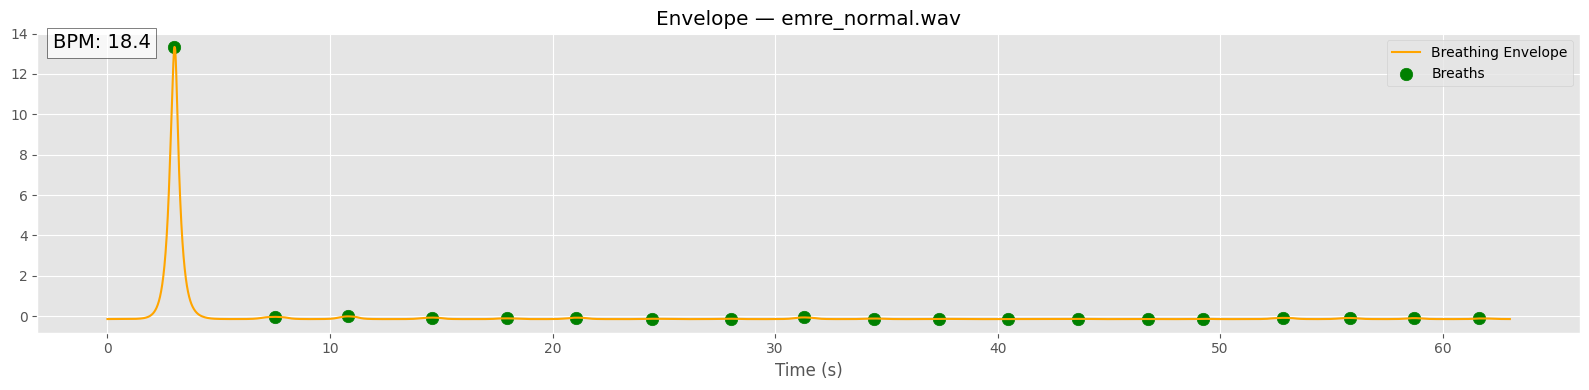

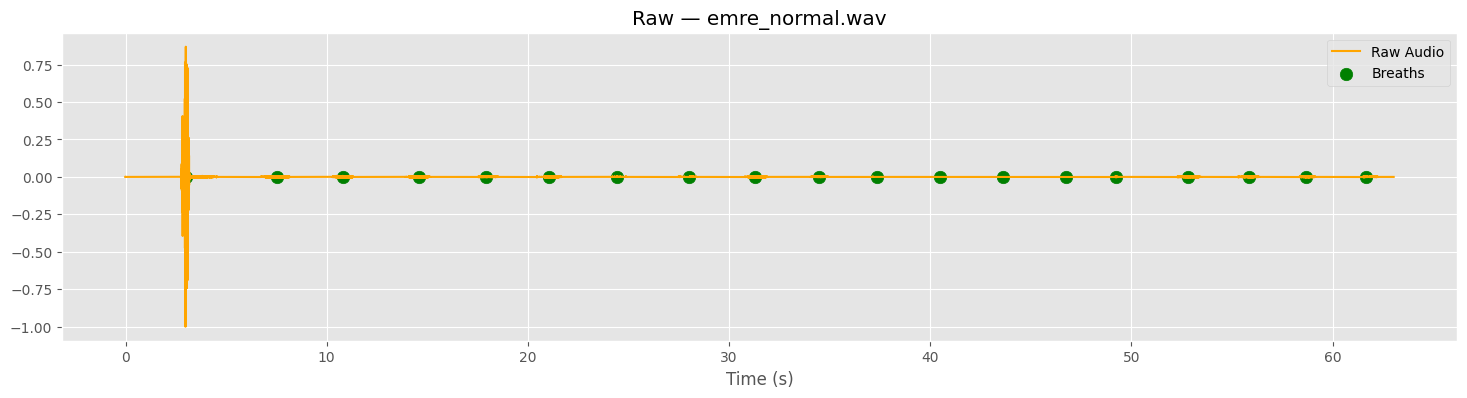

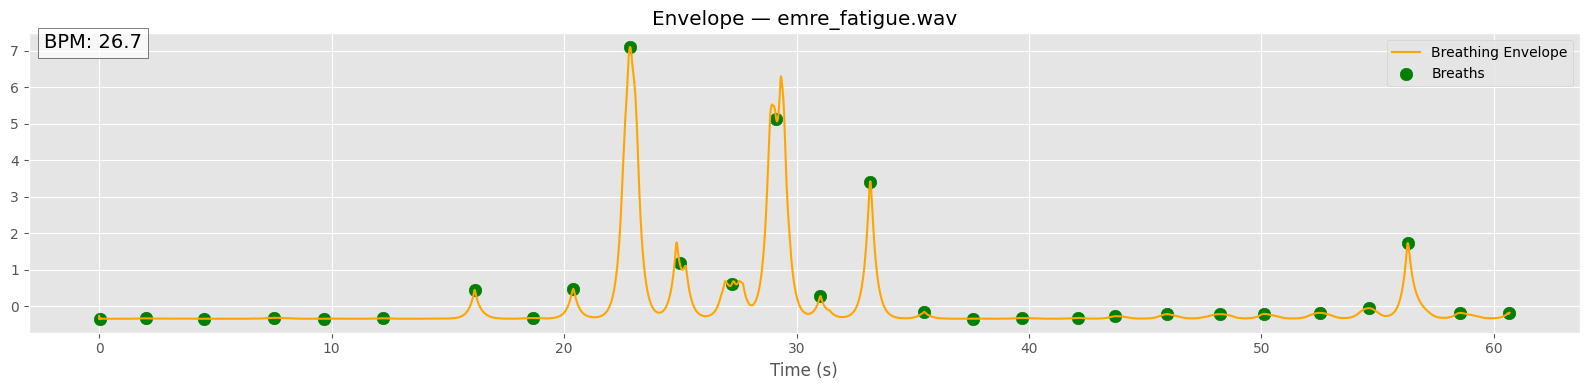

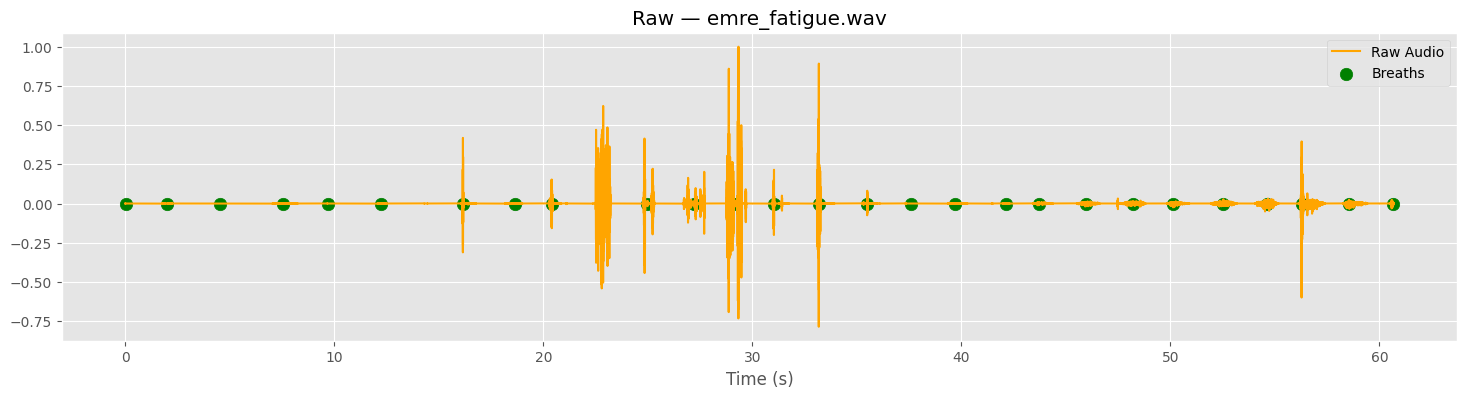

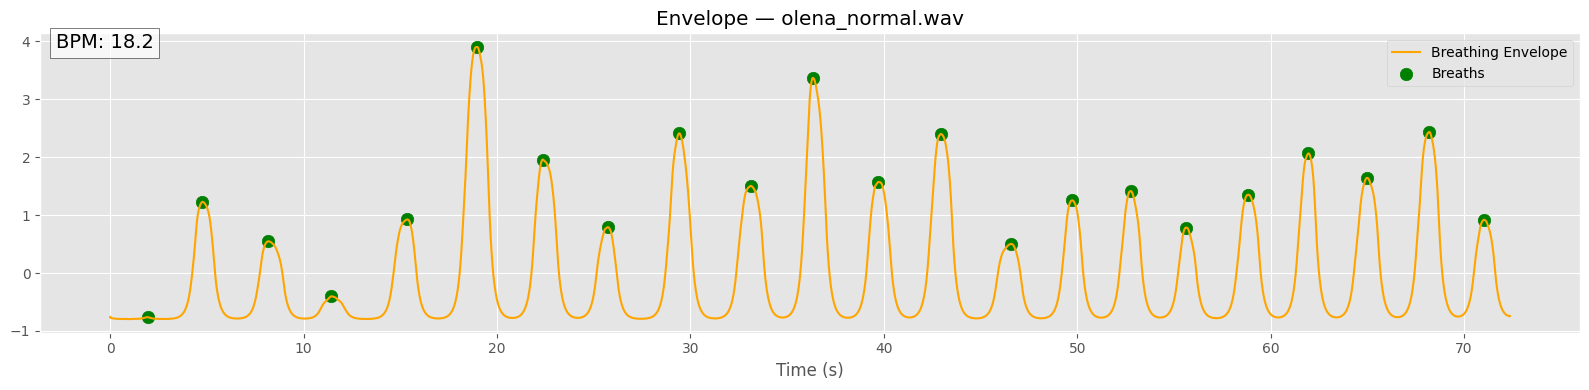

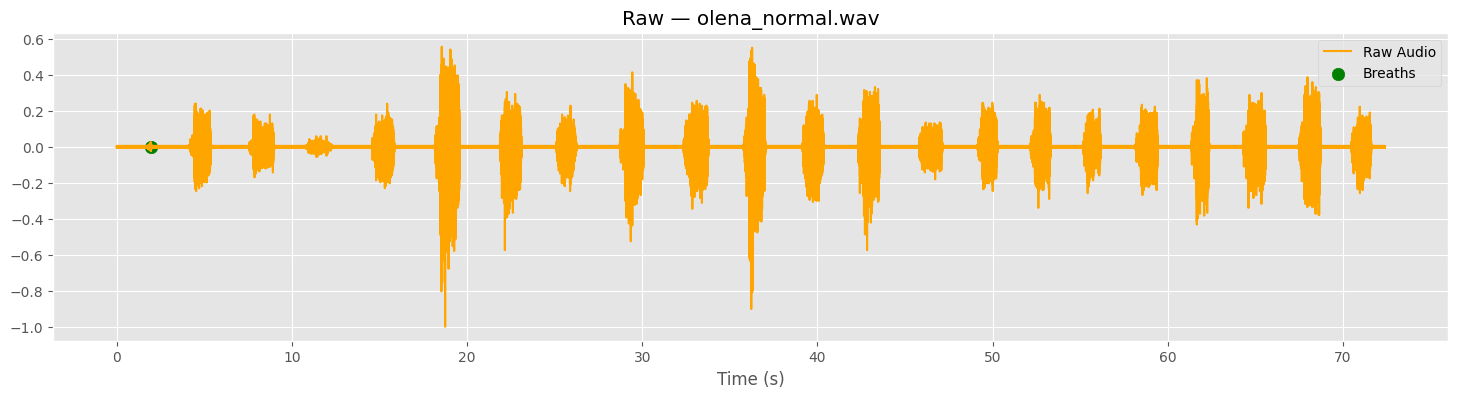

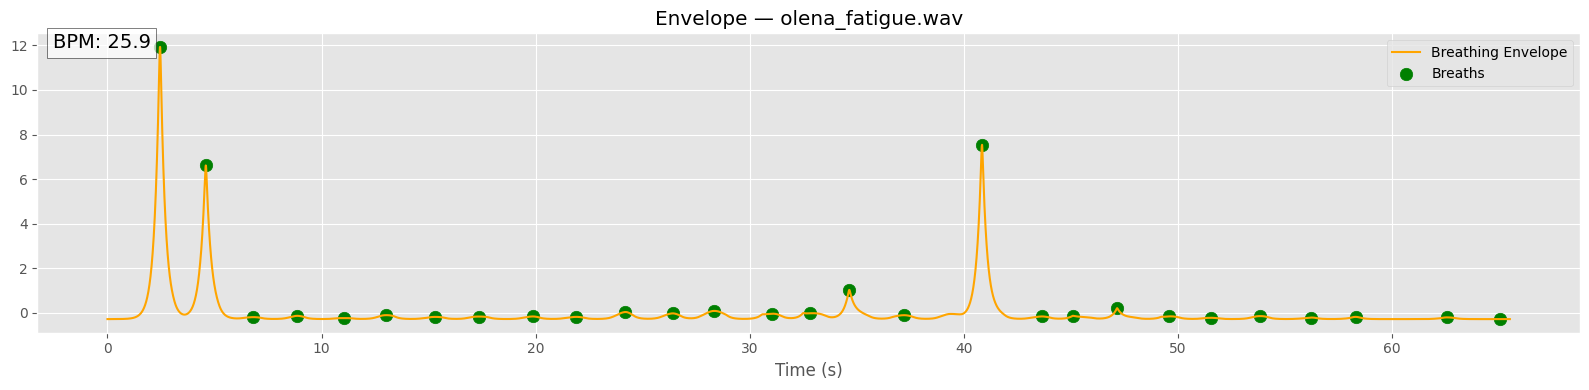

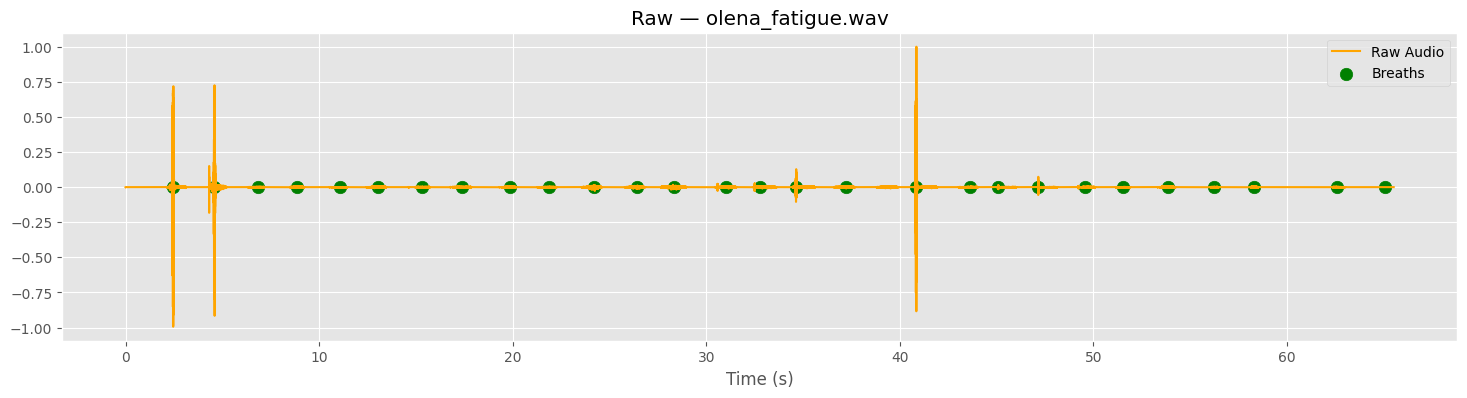

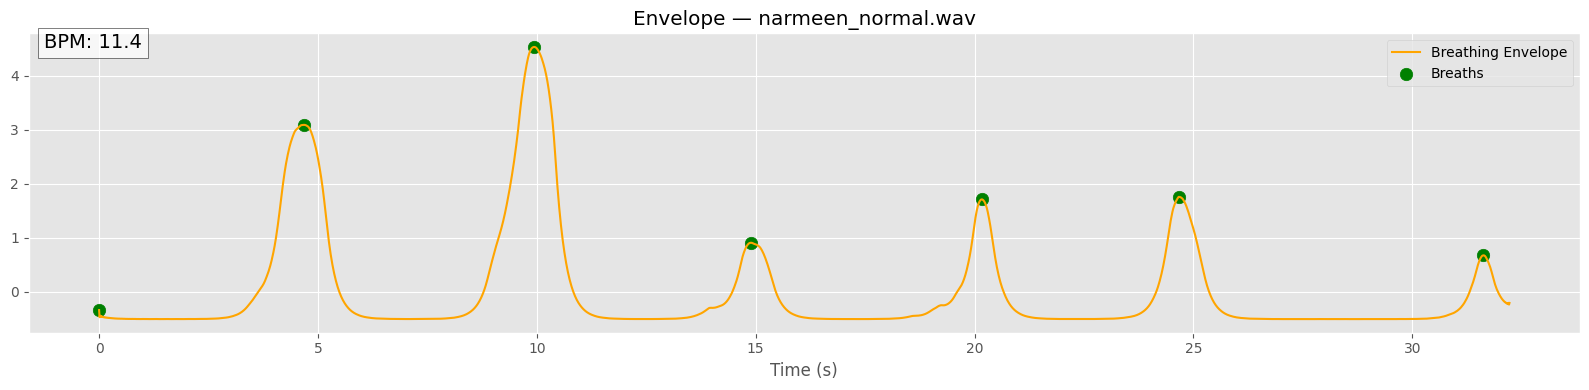

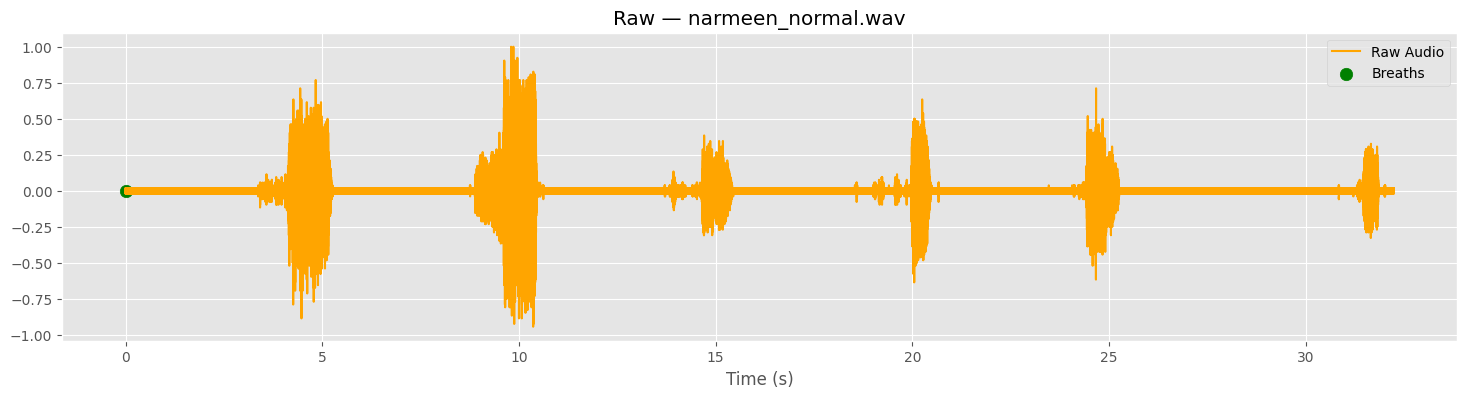

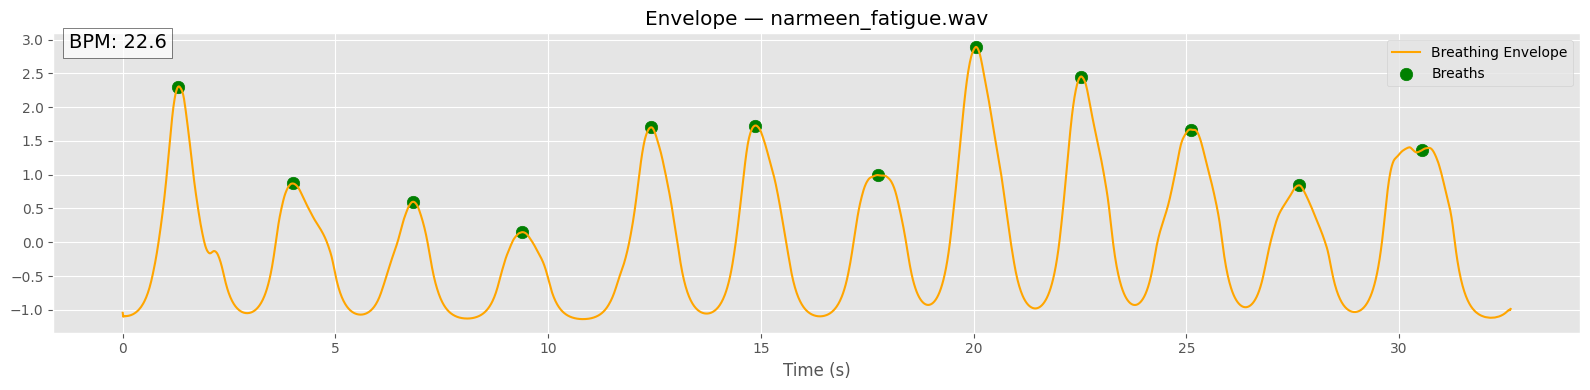

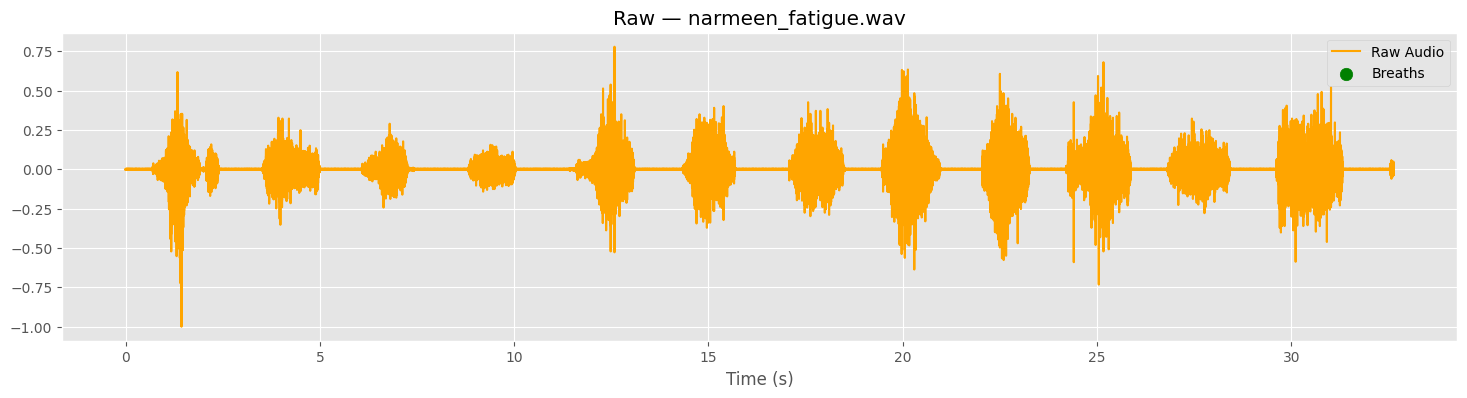

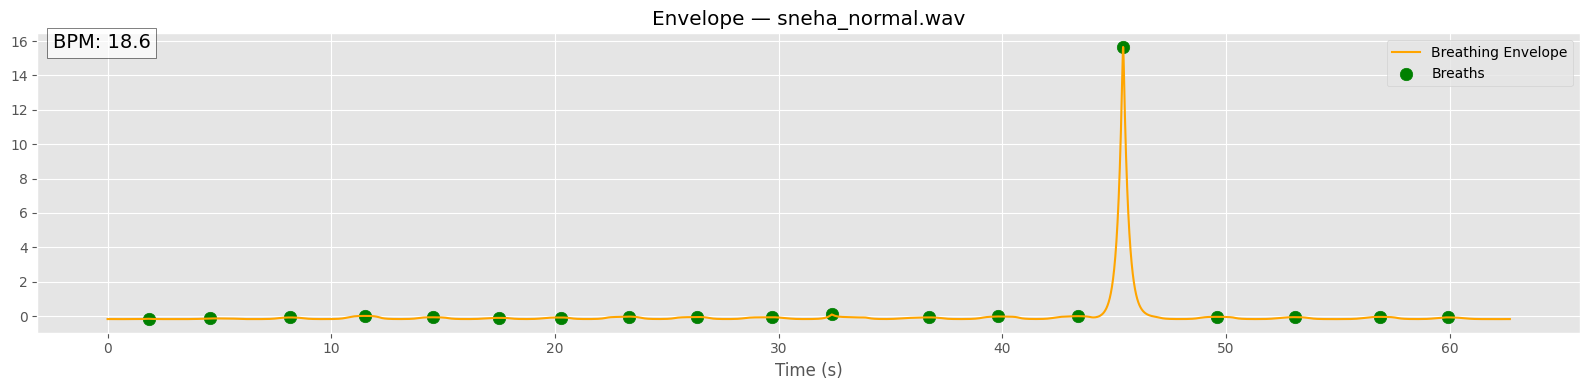

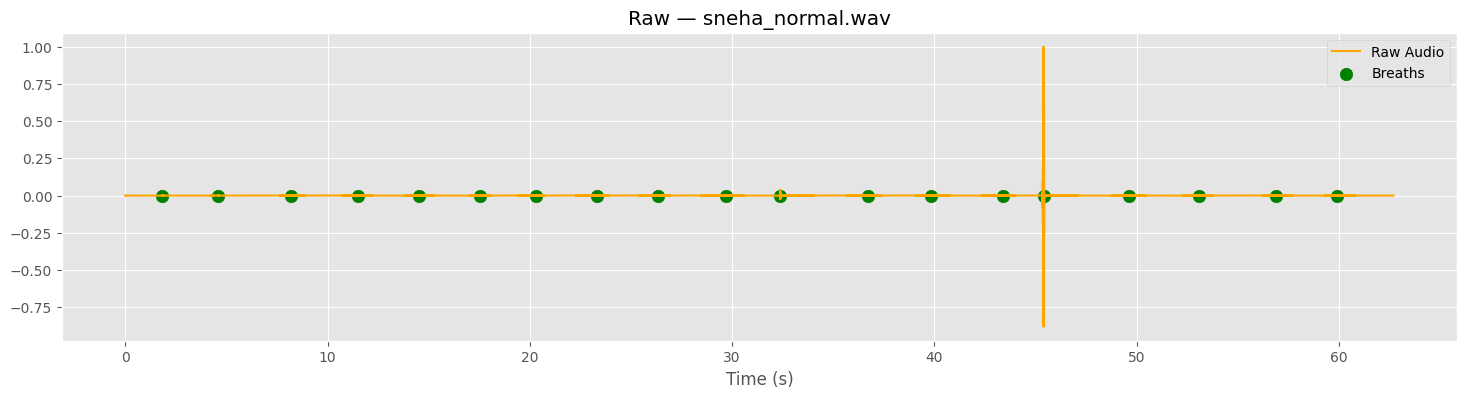

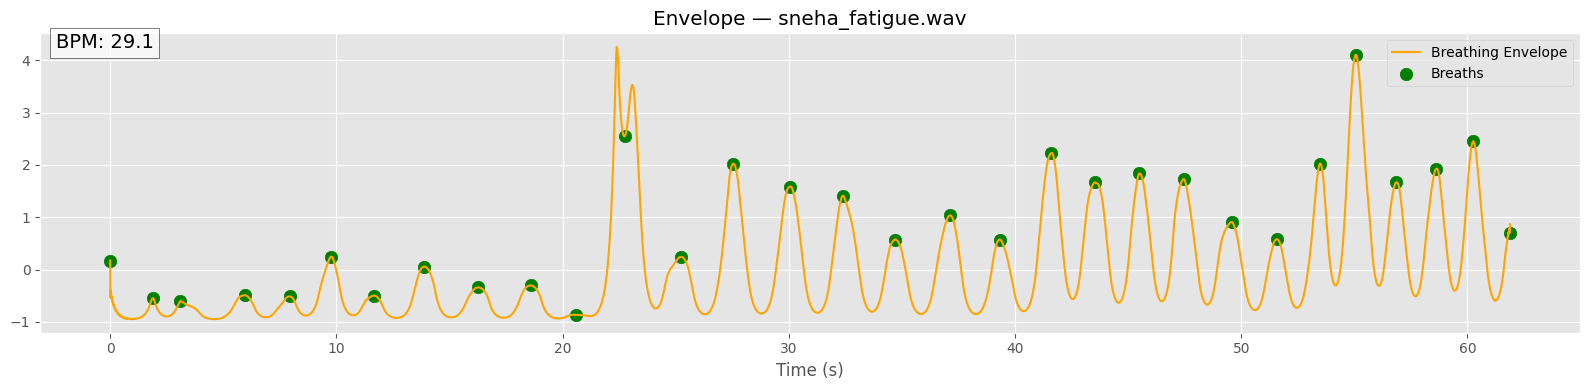

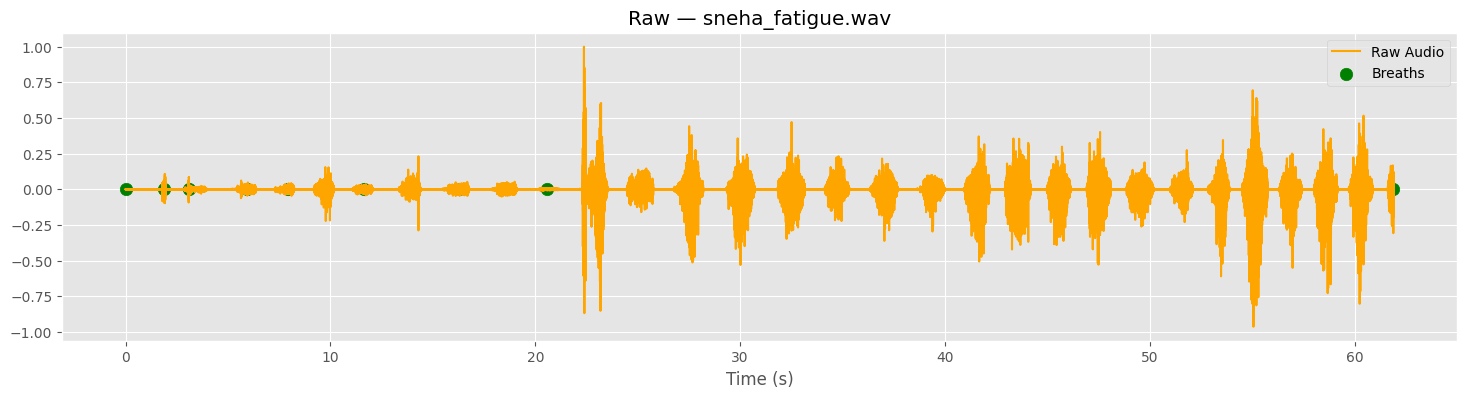

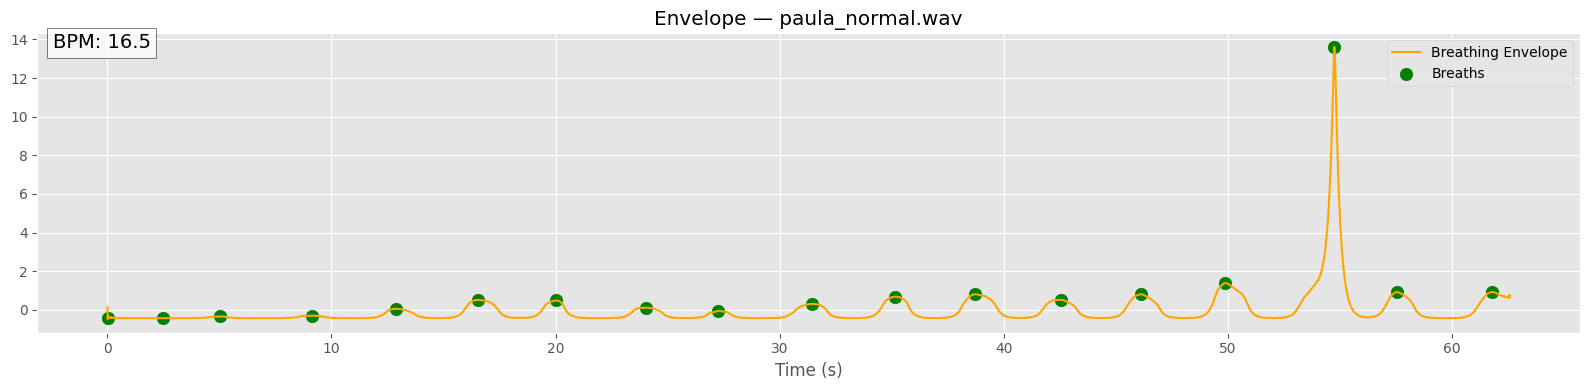

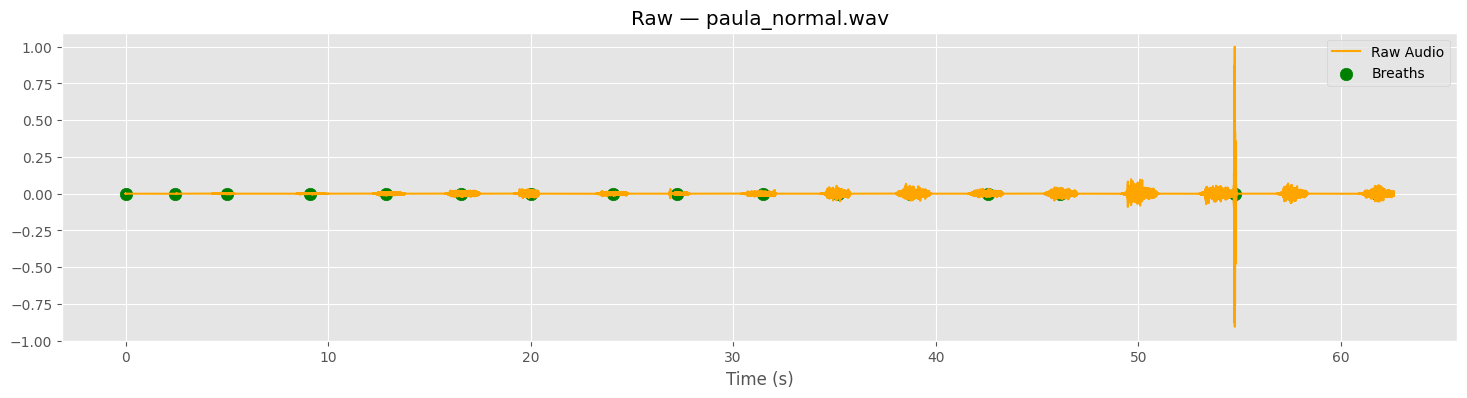

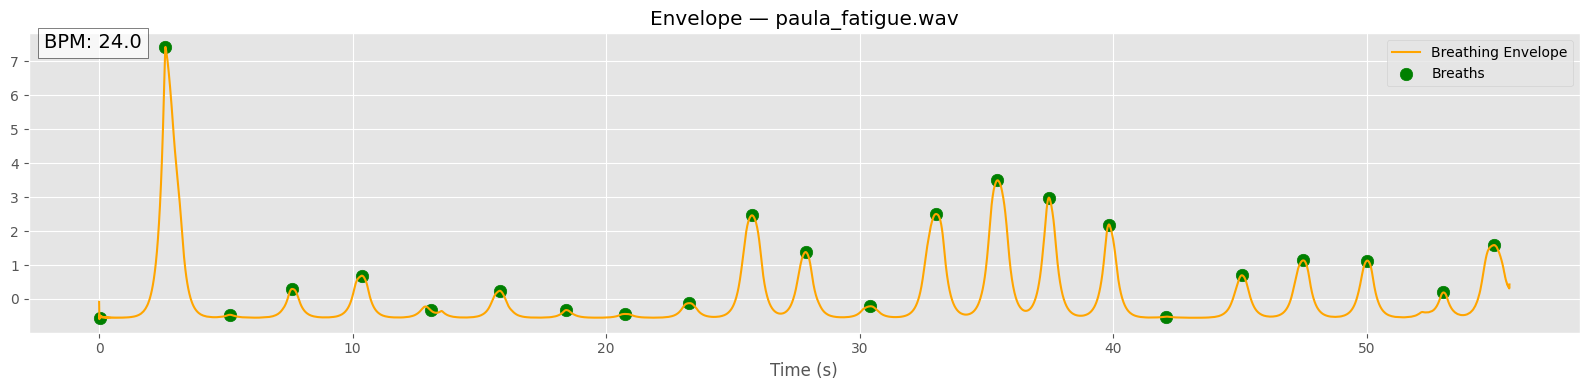

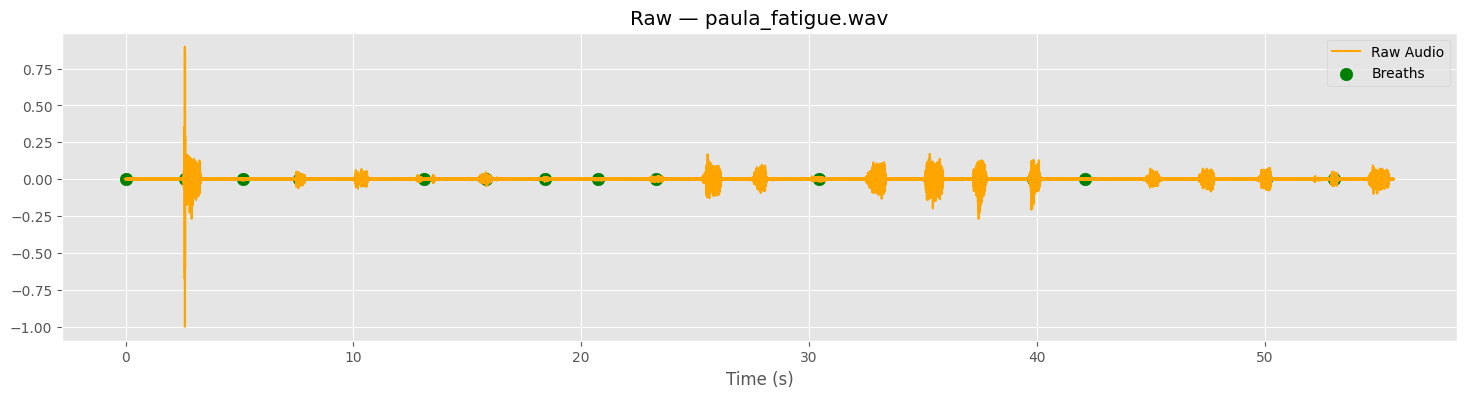

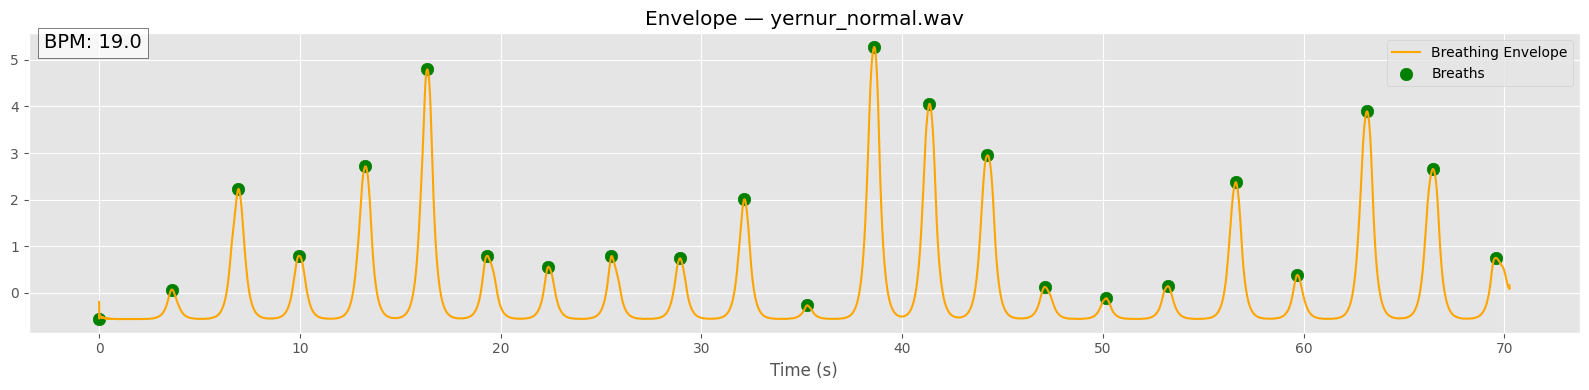

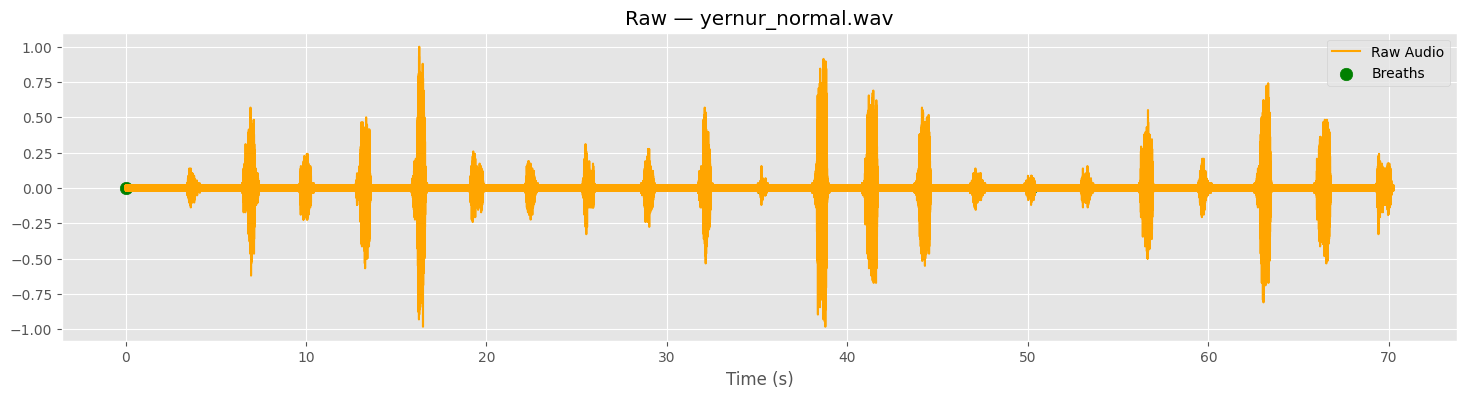

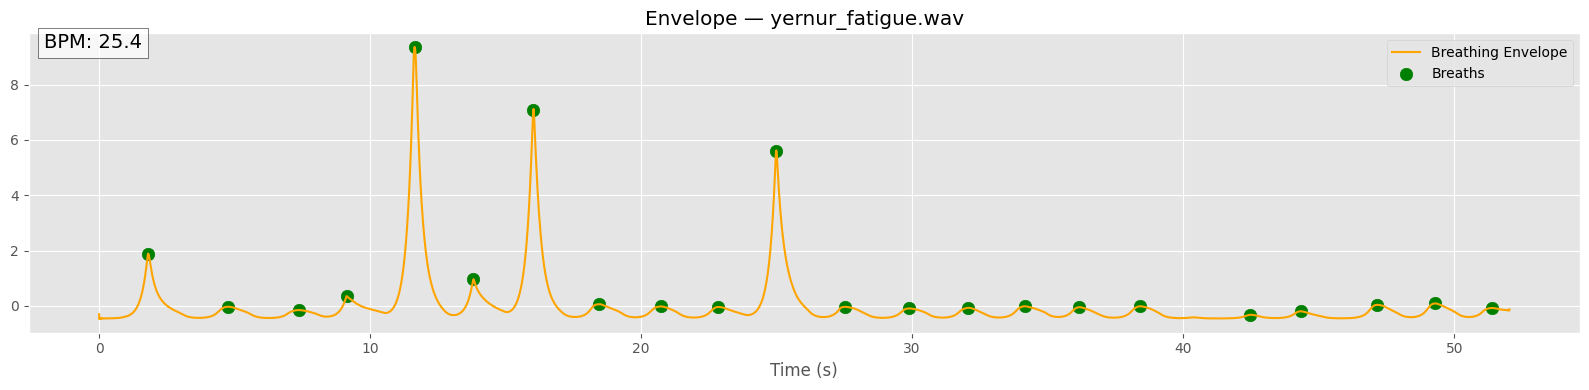

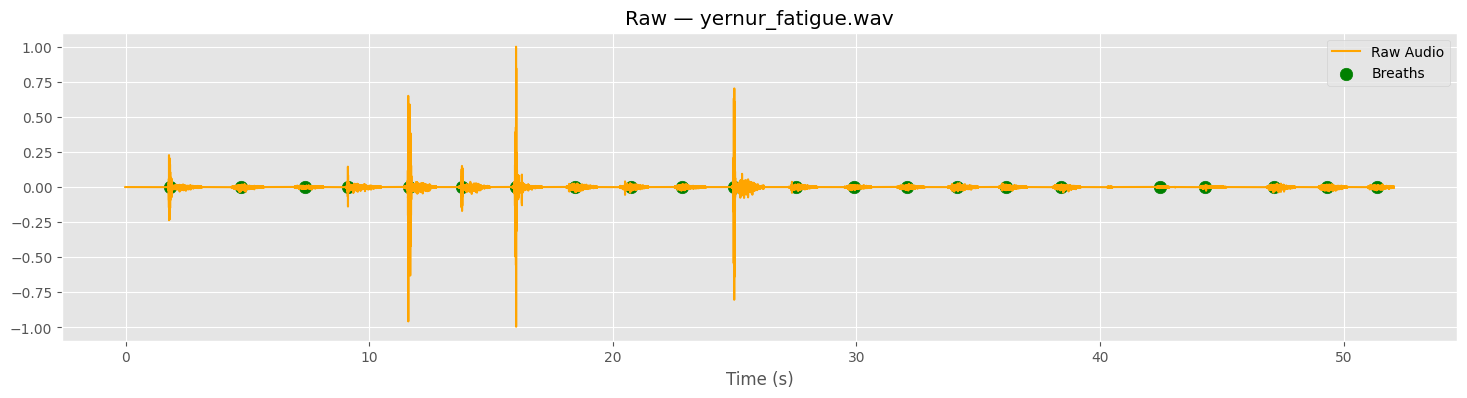

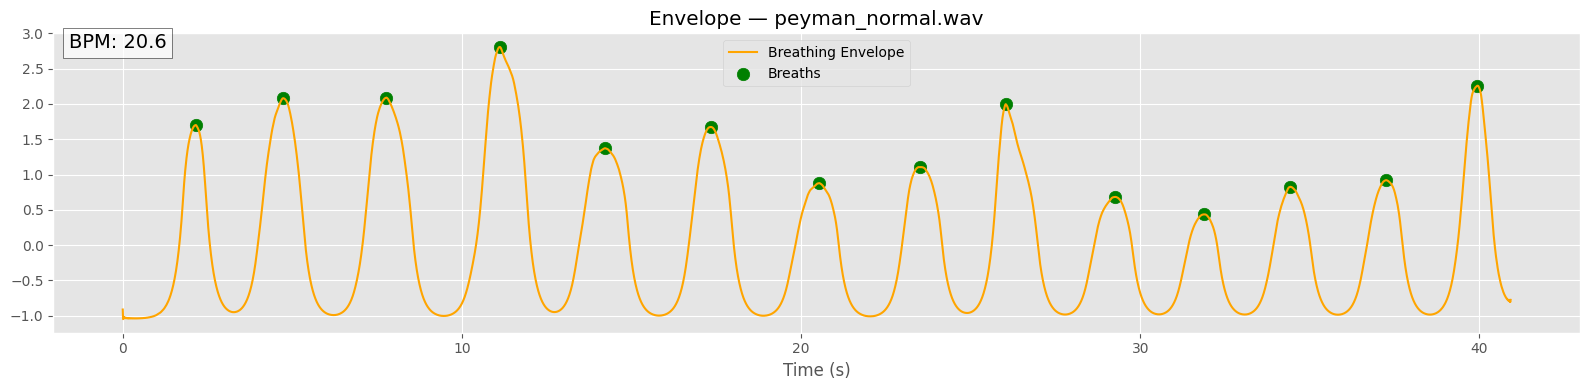

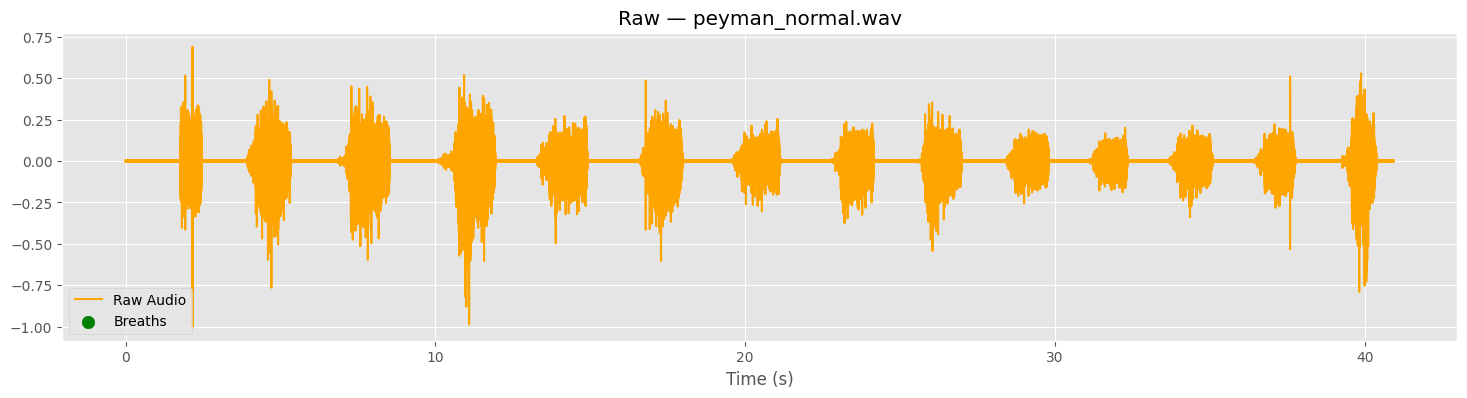

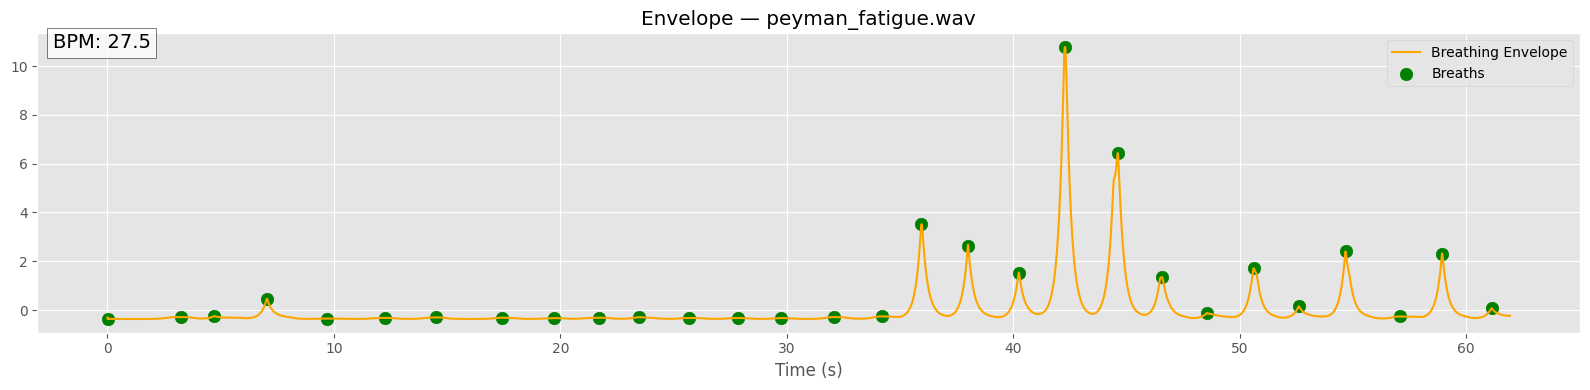

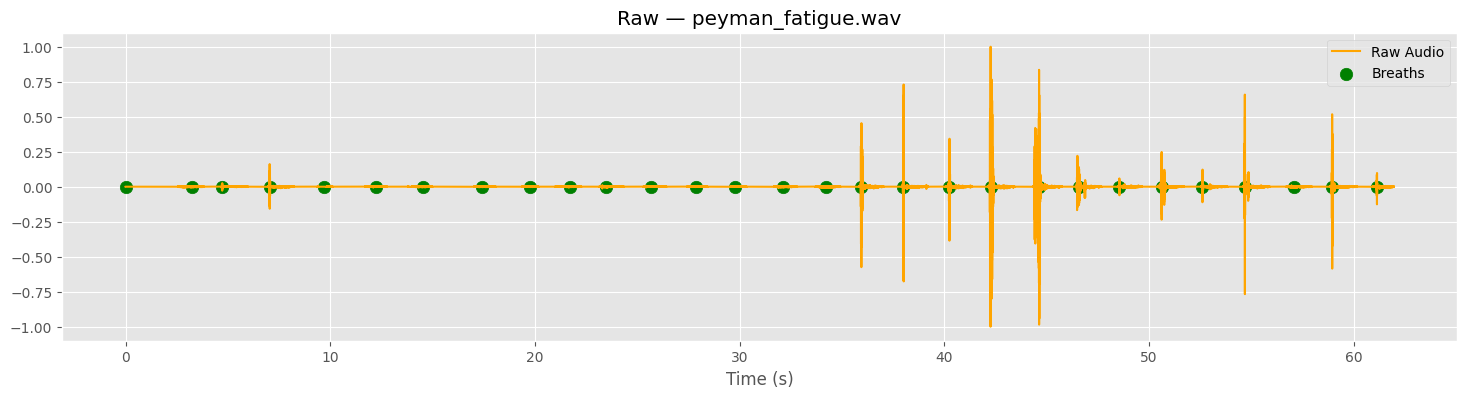

,file,n_breaths,bpm,brv_sdnn,brv_rmssd,brv_cv,label,true_condition
0,emre_normal.wav,19,18.417462,0.424062,0.515638,0.130169,normal,normal
1,emre_fatigue.wav,28,26.732673,0.443466,0.590326,0.197584,fatigue,fatigue
2,olena_normal.wav,22,18.231804,0.290236,0.319186,0.088192,normal,normal
3,olena_fatigue.wav,28,25.882729,0.552275,0.778089,0.238240,fatigue,fatigue
4,narmeen_normal.wav,7,11.385199,0.800479,1.186280,0.151894,normal,normal
5,narmeen_fatigue.wav,12,22.587269,0.217183,0.370365,0.081760,fatigue,fatigue
6,sneha_normal.wav,19,18.591840,0.546644,0.936348,0.169385,normal,normal
7,sneha_fatigue.wav,31,29.093260,0.332182,0.410425,0.161071,fatigue,fatigue
8,paula_normal.wav,18,16.510197,0.604445,0.889807,0.166325,normal,normal
9,paula_fatigue.wav,23,24.000000,0.253539,0.372623,0.101415,fatigue,fatigue


In [119]:
participants = ["emre", "olena", "narmeen", "sneha", "paula", "yernur", "peyman"]
conditions = ["normal", "fatigue"]

results = []

for p in participants:
    for cond in conditions:
        fname = get_file(p, cond)

        out = analyze_breathing_file(fname)   # uses the NEW pipeline
        out["participant"] = p
        out["true_condition"] = cond

        results.append(out)

df = pd.DataFrame(results)

df_prime = df[[
    "file",
    "n_breaths",
    "bpm",
    "brv_sdnn",
    "brv_rmssd",
    "brv_cv",
    "label",
    "true_condition"
]]

df_prime


#### COUGH DETECTION EXPERIMENT

After many experiments, this seems to be the most reliable method, however it doesn't work so well either.

#### Cough detection

In [161]:

def detect_cough_from_envelope(env, sr_env):
    """
    Detect coughs from the breathing envelope itself.
    Coughs appear as very sharp, tall, narrow peaks.
    """
    # coughs have much steeper slopes
    derivative = np.gradient(env)
    derivative_abs = np.abs(derivative)

    # Smooth derivative slightly
    if len(derivative_abs) > 11:
        derivative_smooth = savgol_filter(derivative_abs, 11, 2)
    else:
        derivative_smooth = derivative_abs

    # Normalize
    env_norm = (env - np.mean(env)) / (np.std(env) + 1e-12)
    deriv_norm = (derivative_smooth - np.mean(derivative_smooth)) / (np.std(derivative_smooth) + 1e-12)

    # high amplitude + steep slopes = cough
    cough_score = env_norm + 1.5 * deriv_norm

    # Find peaks
    from scipy.signal import find_peaks

    threshold = np.mean(cough_score) + 1.5 * np.std(cough_score)

    peaks, properties = find_peaks(
        cough_score,
        height=threshold,
        distance=int(0.4 * sr_env)
    )

    if len(peaks) == 0:
        return np.array([])

    validated = []

    for peak_idx in peaks:

        if env_norm[peak_idx] < 1.5:
            continue

        # Check width
        left = peak_idx
        right = peak_idx
        half_height = env[peak_idx] * 0.5

        while left > 0 and env[left] > half_height:
            left -= 1
        while right < len(env)-1 and env[right] > half_height:
            right += 1

        width_sec = (right - left) / sr_env

        # 0.15 to 1.0 seconds
        if 0.15 <= width_sec <= 1.0:
            rise_region = derivative_smooth[max(0, peak_idx-10):peak_idx]
            if len(rise_region) > 0 and np.max(rise_region) > np.mean(derivative_smooth):
                validated.append(peak_idx)

    return np.array(validated)


def detect_cough_from_raw(y, sr):
    """
    Detect coughs from raw audio using energy bursts.
    """
    frame_length = int(0.025 * sr)
    hop_length = int(0.005 * sr)

    # RMS energy
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=hop_length)

    # Smooth
    if len(rms) > 15:
        rms_smooth = savgol_filter(rms, 15, 2)
    else:
        rms_smooth = rms

    # Normalize
    rms_norm = (rms_smooth - np.mean(rms_smooth)) / (np.std(rms_smooth) + 1e-12)

    attack = np.gradient(rms_norm)
    if len(attack) > 11:
        attack_smooth = savgol_filter(attack, 11, 2)
    else:
        attack_smooth = attack

    # Find peaks
    from scipy.signal import find_peaks

    threshold = np.mean(rms_norm) + 1.6 * np.std(rms_norm)

    peaks, _ = find_peaks(
        rms_norm,
        height=threshold,
        distance=int(0.4 * sr / hop_length)
    )

    if len(peaks) == 0:
        return np.array([])

    validated = []

    for peak_idx in peaks:
        left = peak_idx
        right = peak_idx
        half_height = rms_norm[peak_idx] * 0.4

        while left > 0 and rms_norm[left] > half_height:
            left -= 1
        while right < len(rms_norm)-1 and rms_norm[right] > half_height:
            right += 1

        duration = (right - left) * hop_length / sr

        if 0.1 <= duration <= 1.0:
            attack_region = attack_smooth[max(0, peak_idx-20):peak_idx]
            if len(attack_region) > 2 and np.max(attack_region) > 0.25:
                validated.append(times[peak_idx])

    return np.array(validated)


def detect_cough_events(y, sr, env, sr_env):
    """
    Detect coughs using BOTH raw signal and envelope.
    Take union of both detections for better coverage.
    """
    # Method 1: From envelope
    envelope_peaks = detect_cough_from_envelope(env, sr_env)
    envelope_times = envelope_peaks / sr_env

    # Method 2: From raw audio
    raw_times = detect_cough_from_raw(y, sr)

    # union
    all_coughs = np.concatenate([envelope_times, raw_times])

    if len(all_coughs) == 0:
        return np.array([])

    # Sort
    all_coughs = np.sort(all_coughs)

    # Merge coughs that are very close
    merged = []
    i = 0
    while i < len(all_coughs):
        current = all_coughs[i]
        while i + 1 < len(all_coughs) and all_coughs[i+1] - current < 0.3:
            i += 1
        merged.append(current)
        i += 1

    return np.array(merged)




#### remove overlapping breaths



In [163]:
def remove_overlapping_breaths(breath_peaks, breath_sr, cough_times, overlap_window=0.5):
    """
    Remove breath detections that overlap with cough detections.
    """
    if len(cough_times) == 0:
        return breath_peaks

    if len(breath_peaks) == 0:
        return breath_peaks

    breath_times = breath_peaks / breath_sr

    filtered_breaths = []
    for i, bt in enumerate(breath_times):
        min_dist = np.min(np.abs(cough_times - bt))
        if min_dist > overlap_window:
            filtered_breaths.append(breath_peaks[i])

    return np.array(filtered_breaths, dtype=int)




#### Analysize one file

In [164]:
def analyze_breathing_and_coughs(filename):
    """
    Complete analysis: detect both breaths and coughs.
    """
    y, sr = load_audio(filename)

    # 1. BREATH DETECTION
    env, sr_env = extract_breathing_envelope(y, sr)
    peaks, bpm, brv = detect_breath_peaks(env, sr_env)

    # 2. COUGH DETECTION
    cough_times = detect_cough_events(y, sr, env, sr_env)
    n_coughs = len(cough_times)

    # 3. Remove breaths that overlap with coughs
    peaks_filtered = remove_overlapping_breaths(peaks, sr_env, cough_times)

    # Recalculate BPM and BRV with filtered breaths
    if len(peaks_filtered) < 2:
        bpm_filtered = 0
        brv_filtered = {"sdnn":0, "rmssd":0, "cv":0, "mean_ibi":0}
    else:
        intervals = np.diff(peaks_filtered) / sr_env
        bpm_filtered = 60 / np.mean(intervals)
        brv_filtered = compute_brv_from_peaks(peaks_filtered, sr_env)

    # 4. Classification
    label = classify_breathing(
        bpm_filtered,
        brv_filtered["sdnn"],
        brv_filtered["rmssd"],
        brv_filtered["cv"],
        len(peaks_filtered)
    )

    # 5. Plots
    plot_envelope_with_coughs_and_breaths(
        env, sr_env, peaks_filtered, cough_times, bpm_filtered,
        title=f"Analysis — {filename}"
    )

    return {
        "file": filename,
        "n_breaths": len(peaks_filtered),
        "n_coughs": n_coughs,
        "bpm": bpm_filtered,
        "brv_sdnn": brv_filtered["sdnn"],
        "brv_rmssd": brv_filtered["rmssd"],
        "brv_cv": brv_filtered["cv"],
        "label": label
    }


def plot_envelope_with_coughs_and_breaths(env, sr_env, breath_peaks, cough_times, bpm, title="Analysis"):
    """
    Plot envelope with both breath peaks and cough events marked.
    """
    t = np.arange(len(env)) / sr_env
    plt.figure(figsize=(18, 5))

    # Plot envelope
    plt.plot(t, env, color="orange", label="Breathing Envelope", alpha=0.7)

    # Plot breath peaks
    if len(breath_peaks) > 0:
        plt.scatter(breath_peaks / sr_env, env[breath_peaks],
                   s=100, c="green", marker='o', label="Breaths", zorder=3)

    # Plot cough events
    for ct in cough_times:
        plt.axvline(ct, color='red', linestyle='--', alpha=0.6, linewidth=2)

    if len(cough_times) > 0:
        plt.axvline(cough_times[0], color='red', linestyle='--',
                   alpha=0.6, linewidth=2, label="Coughs")

    # Annotate
    plt.text(0.01, 0.95,
            f"BPM: {bpm:.1f}\nBreaths: {len(breath_peaks)}\nCoughs: {len(cough_times)}",
            transform=plt.gca().transAxes,
            fontsize=12,
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"))

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized Amplitude")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


#### Run main analysis

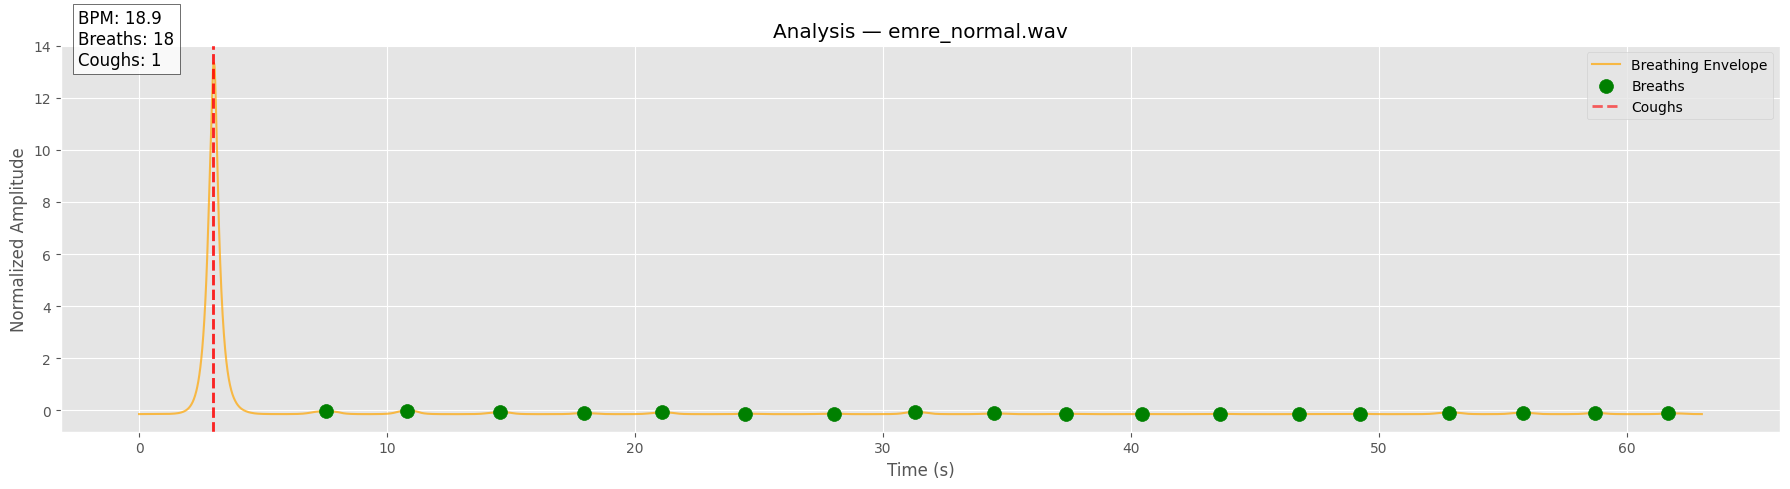

✓ emre_normal.wav: 18 breaths, 1 coughs


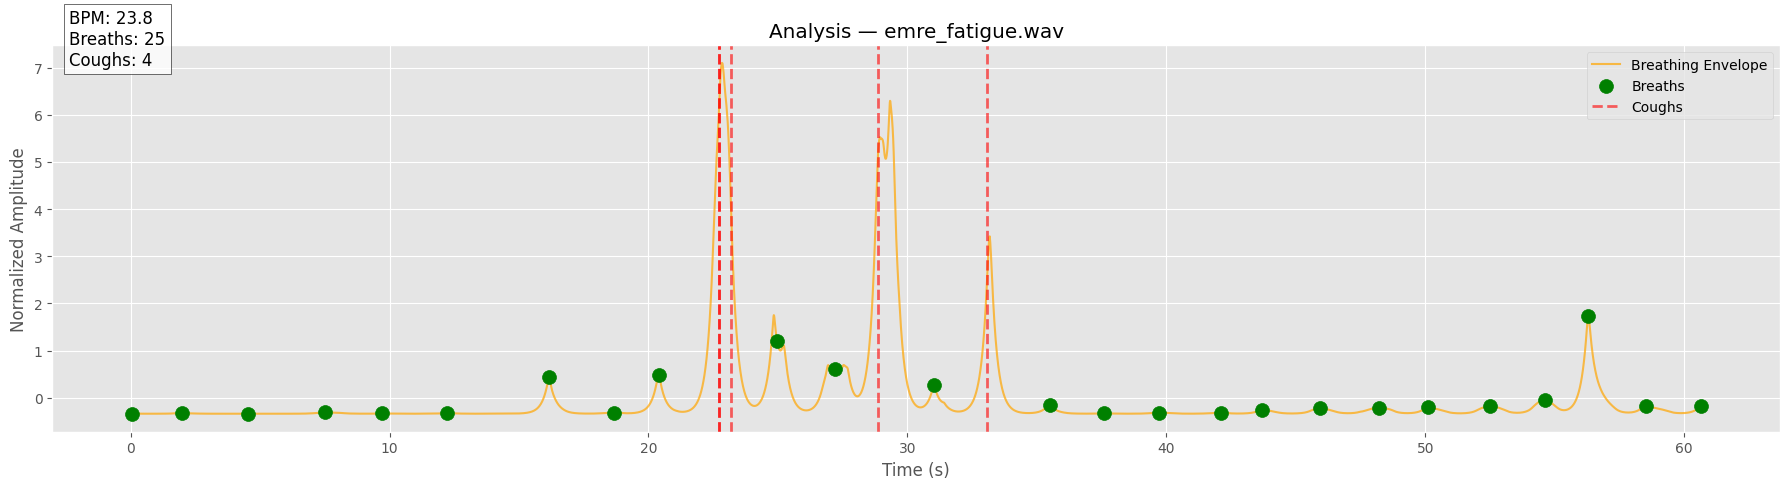

✓ emre_fatigue.wav: 25 breaths, 4 coughs


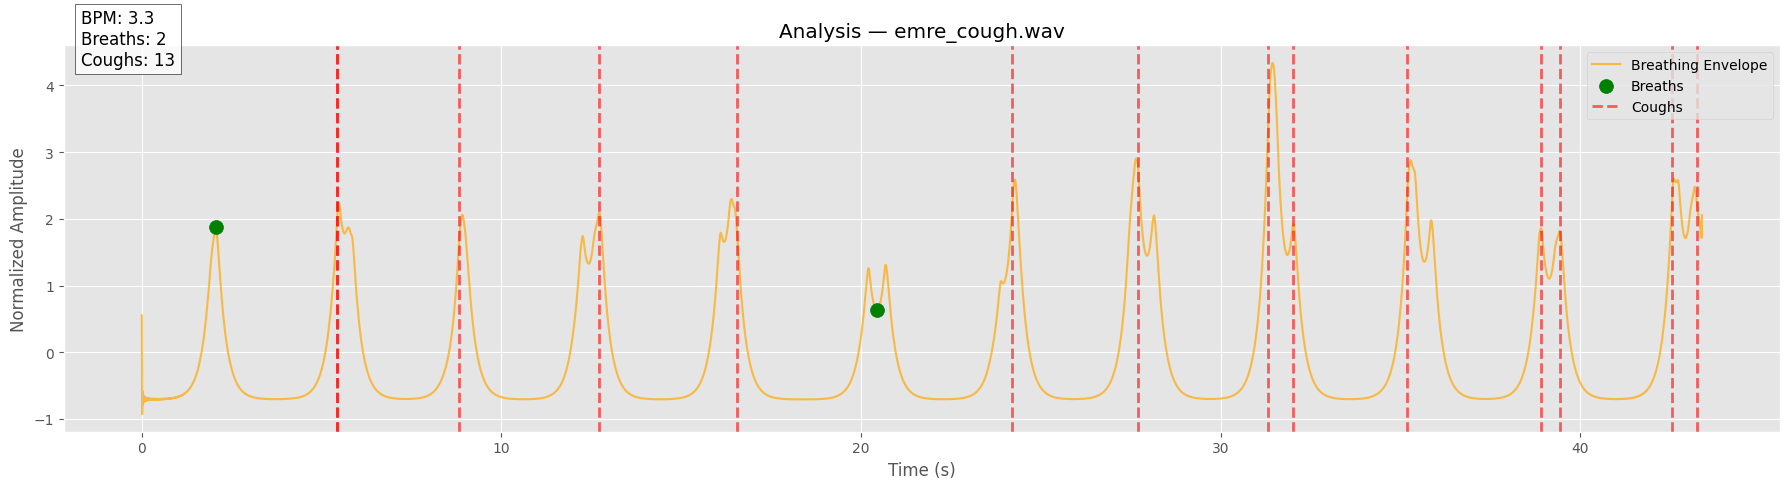

✓ emre_cough.wav: 2 breaths, 13 coughs


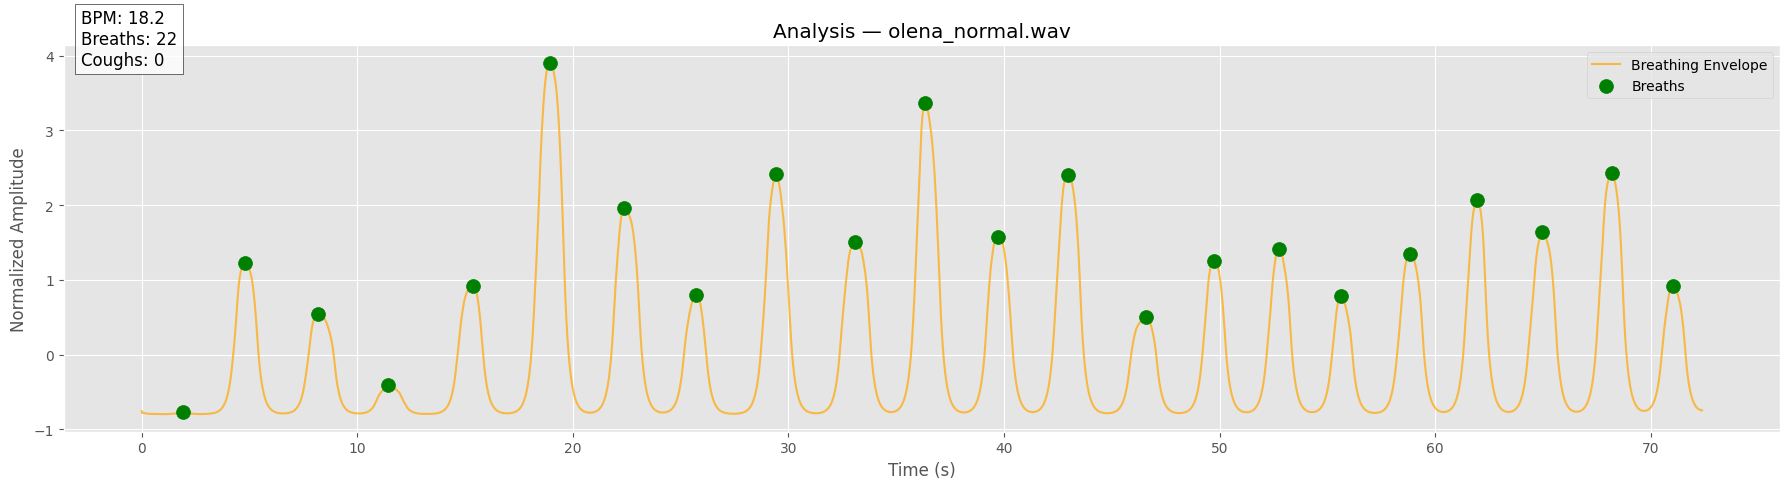

✓ olena_normal.wav: 22 breaths, 0 coughs


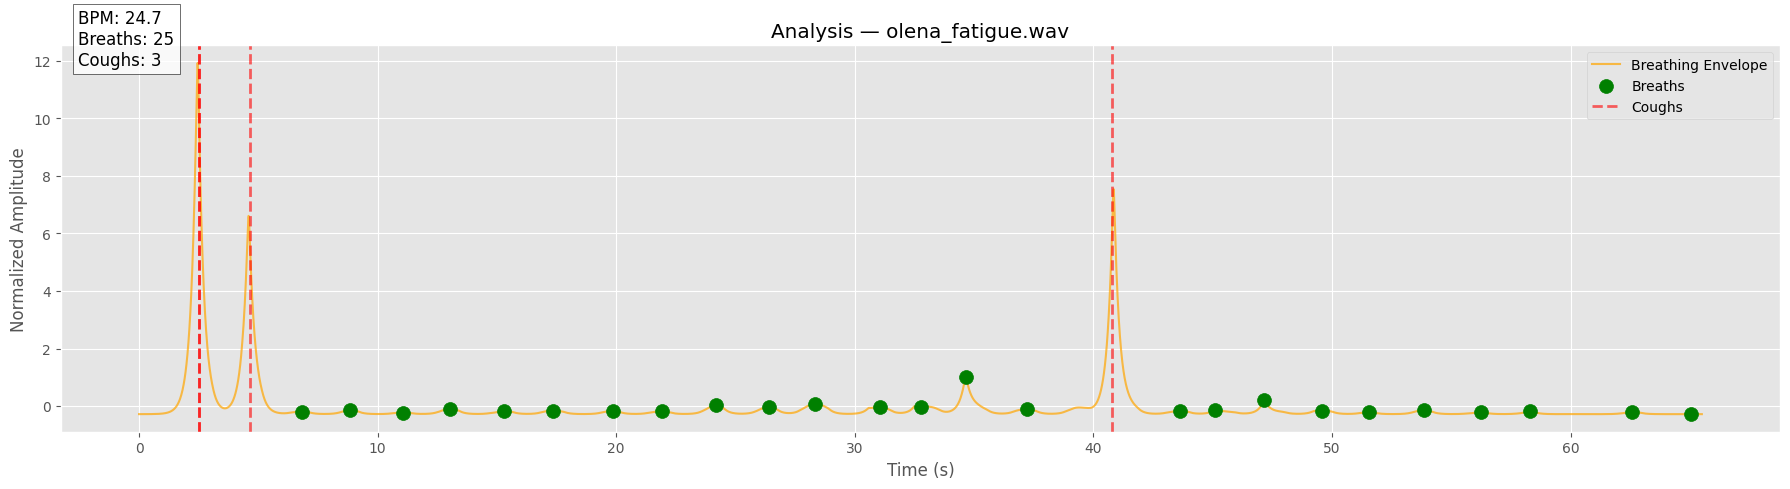

✓ olena_fatigue.wav: 25 breaths, 3 coughs


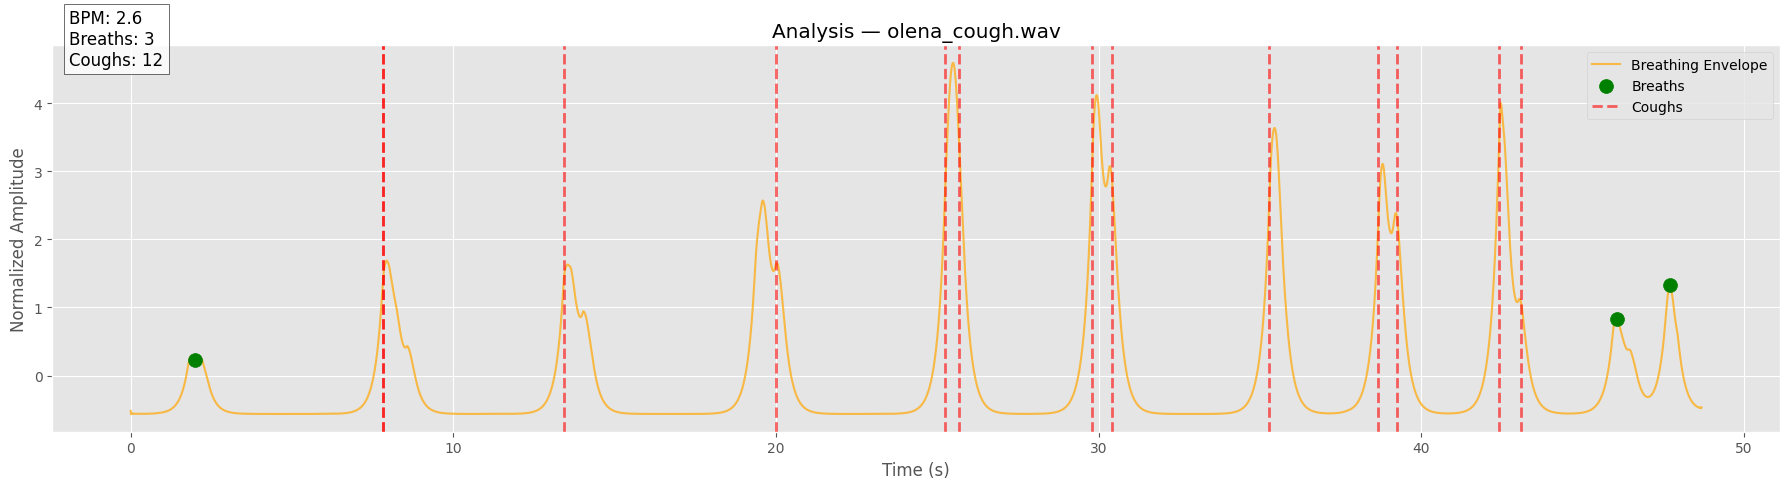

✓ olena_cough.wav: 3 breaths, 12 coughs


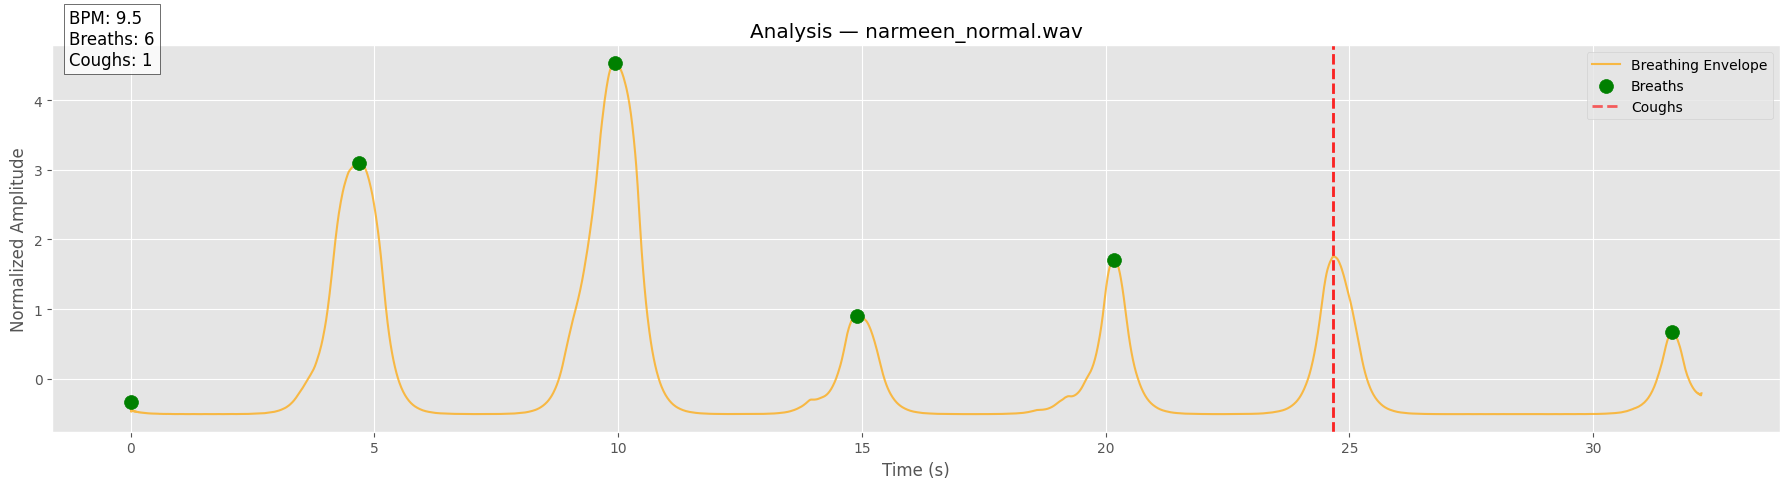

✓ narmeen_normal.wav: 6 breaths, 1 coughs


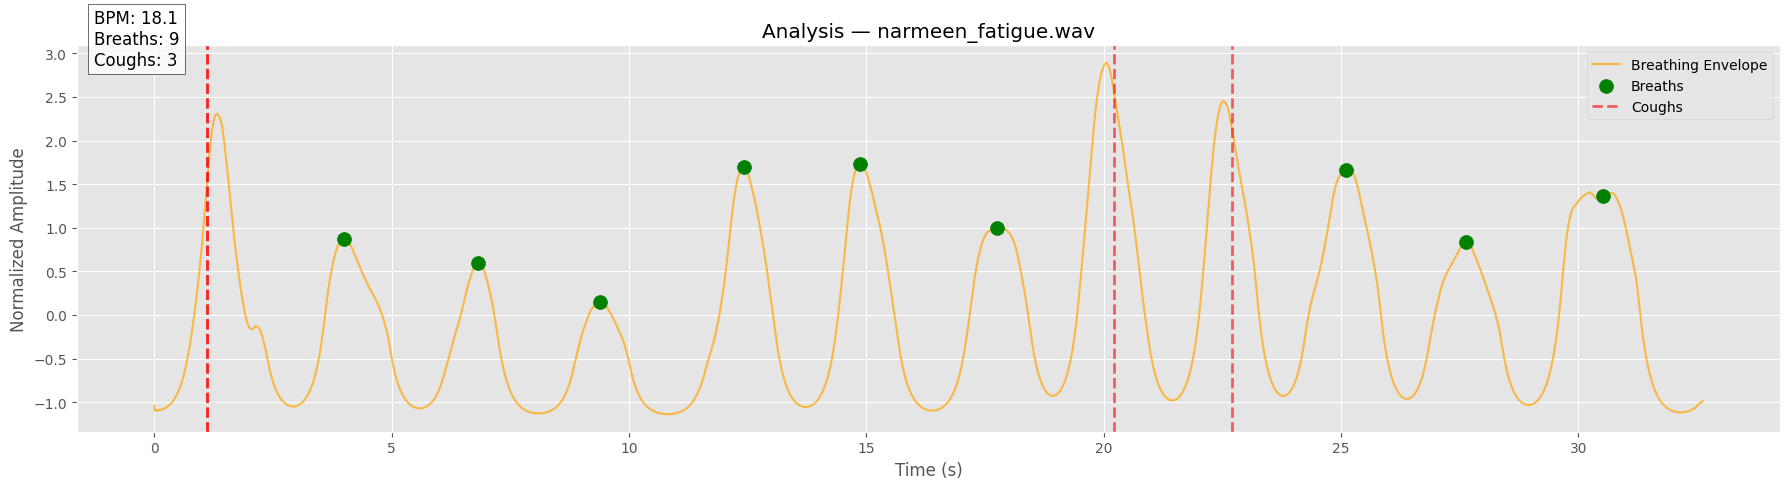

✓ narmeen_fatigue.wav: 9 breaths, 3 coughs


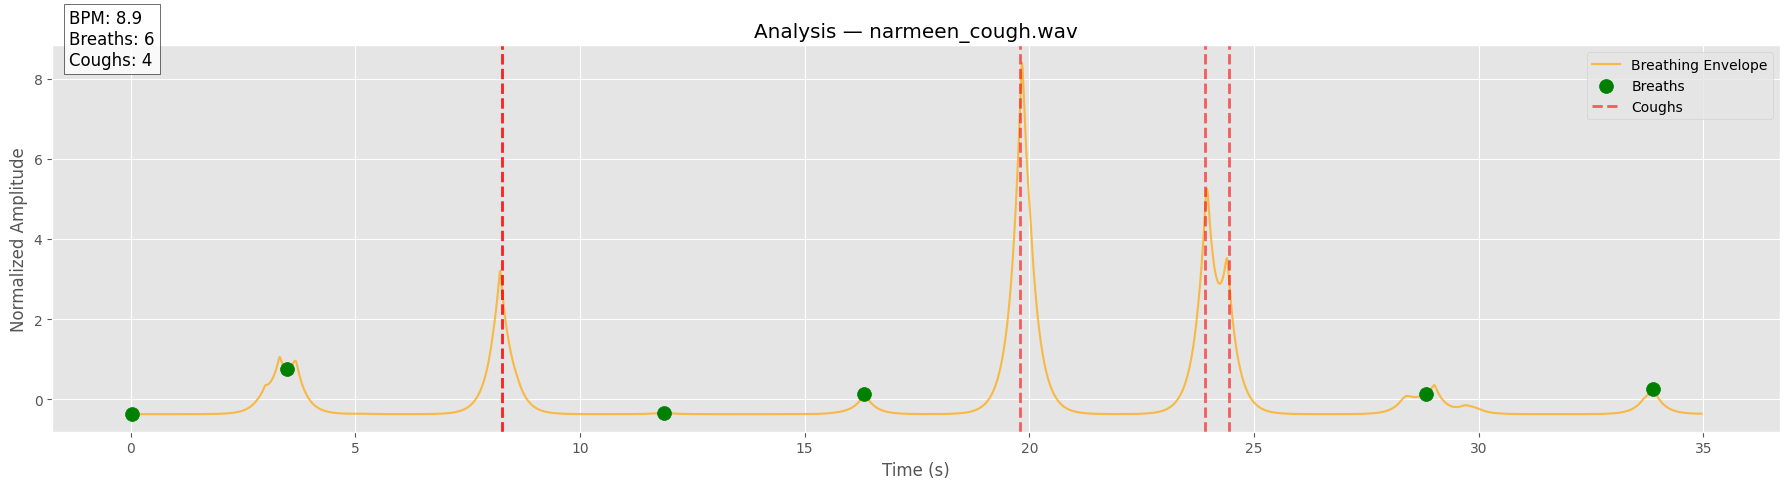

✓ narmeen_cough.wav: 6 breaths, 4 coughs


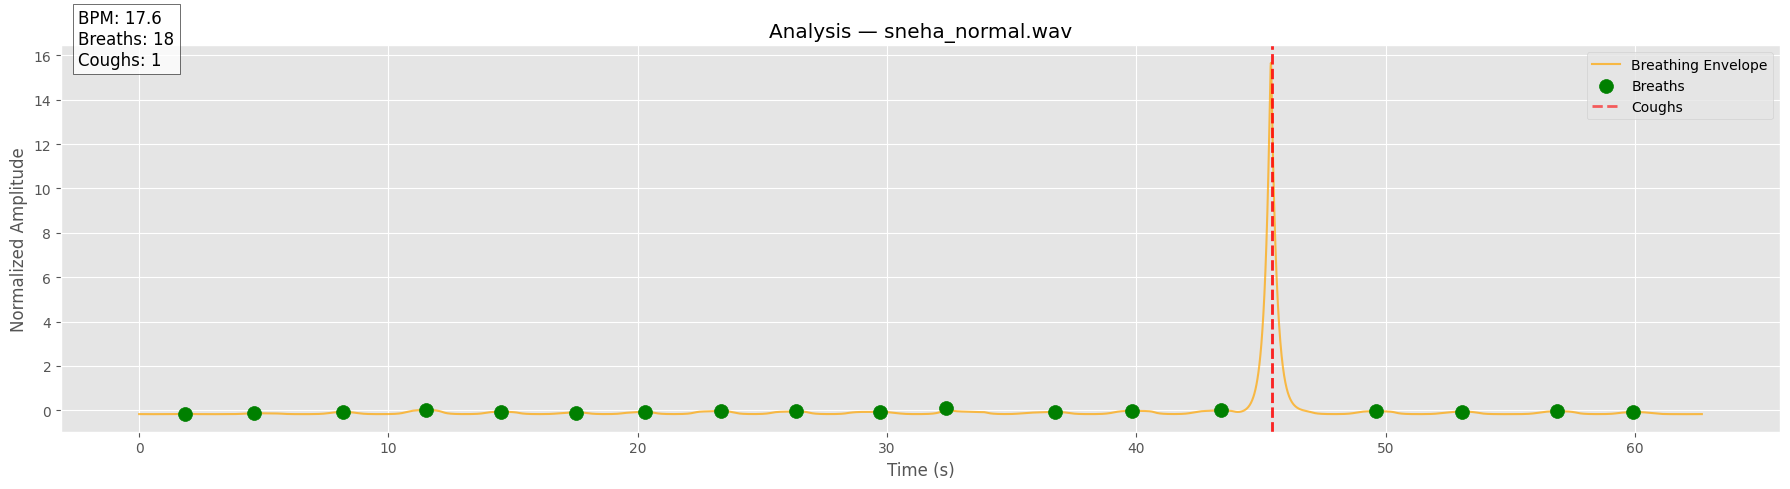

✓ sneha_normal.wav: 18 breaths, 1 coughs


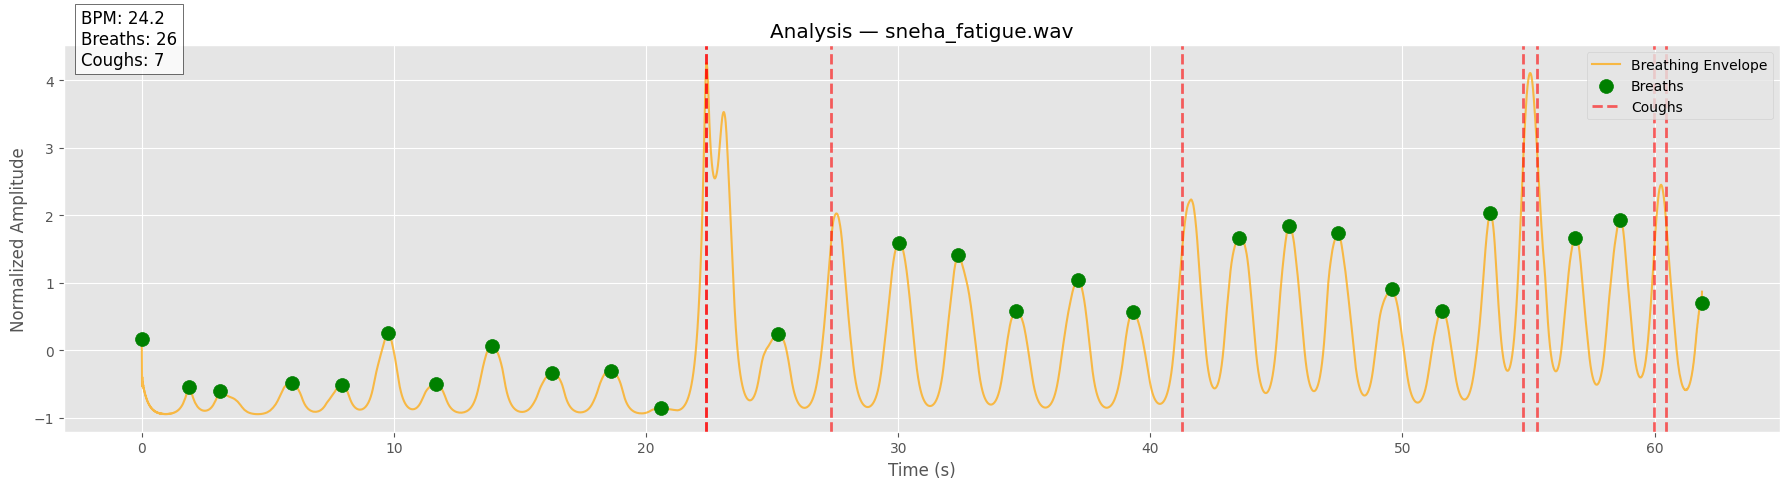

✓ sneha_fatigue.wav: 26 breaths, 7 coughs


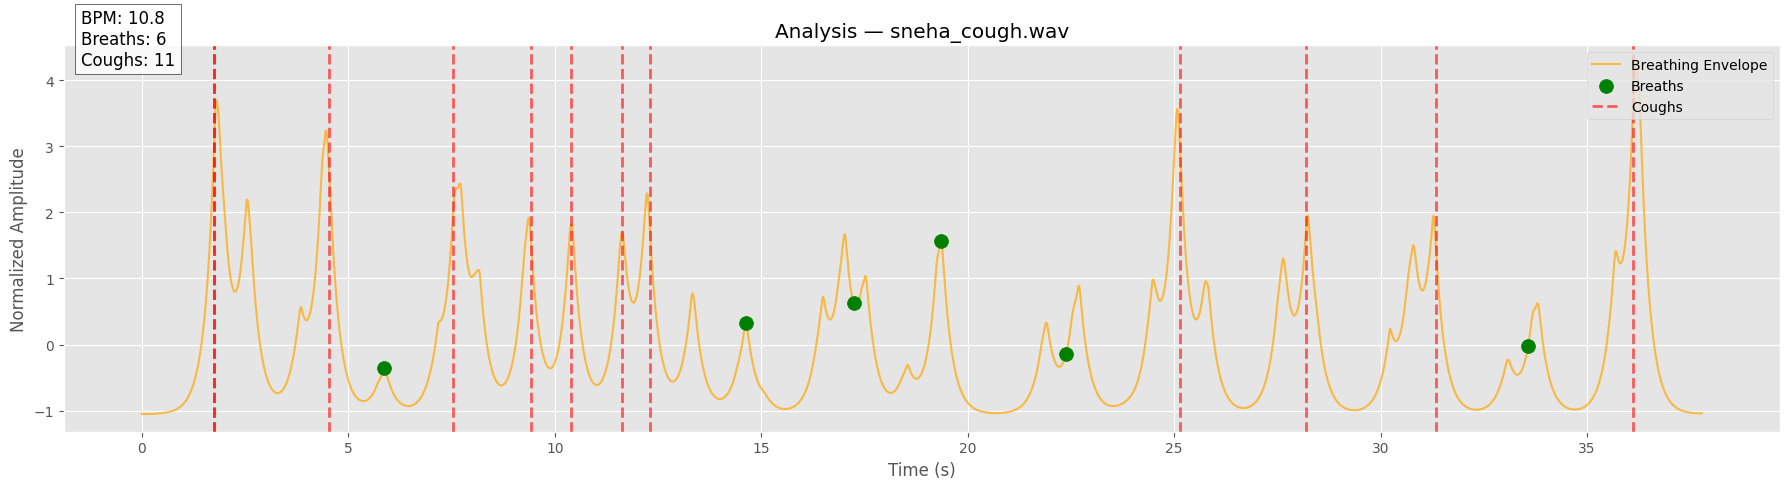

✓ sneha_cough.wav: 6 breaths, 11 coughs


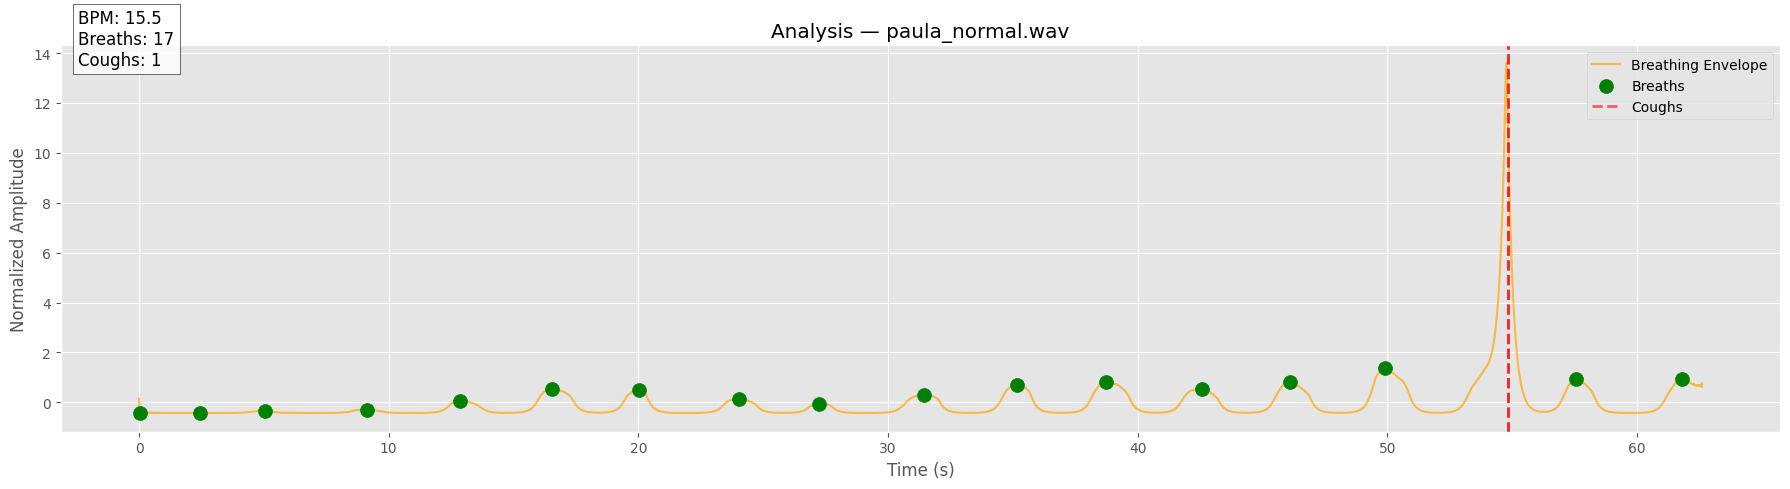

✓ paula_normal.wav: 17 breaths, 1 coughs


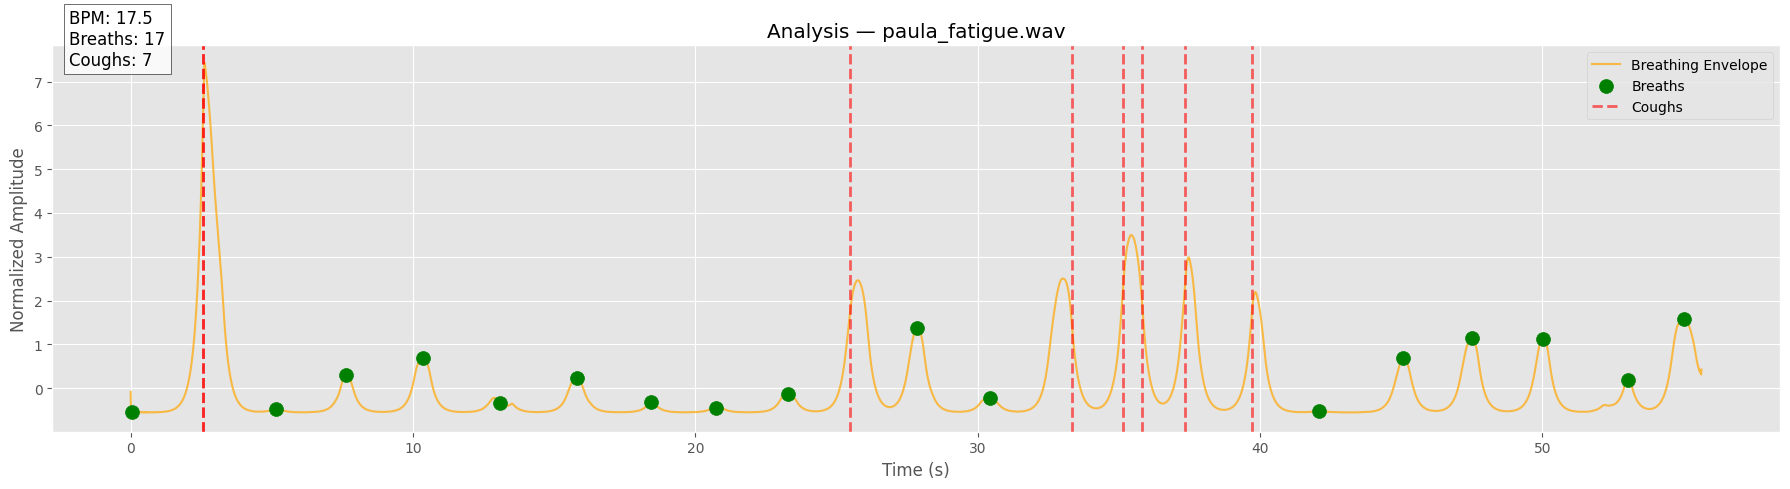

✓ paula_fatigue.wav: 17 breaths, 7 coughs


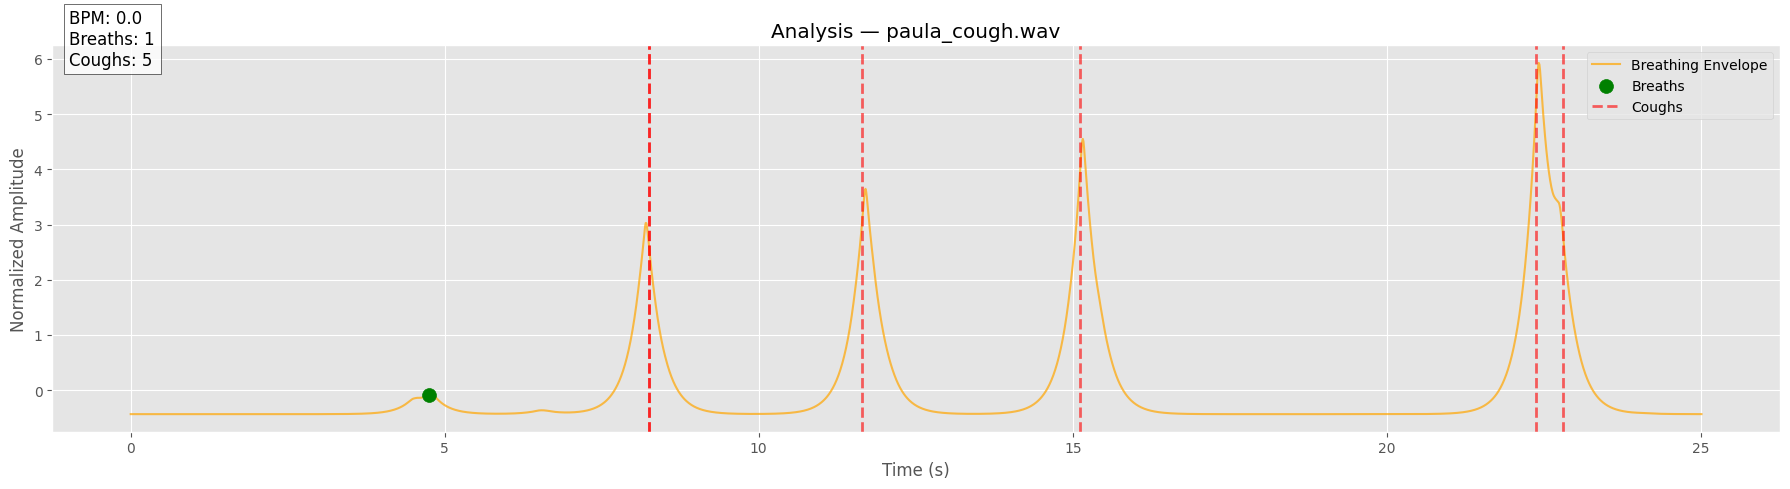

✓ paula_cough.wav: 1 breaths, 5 coughs


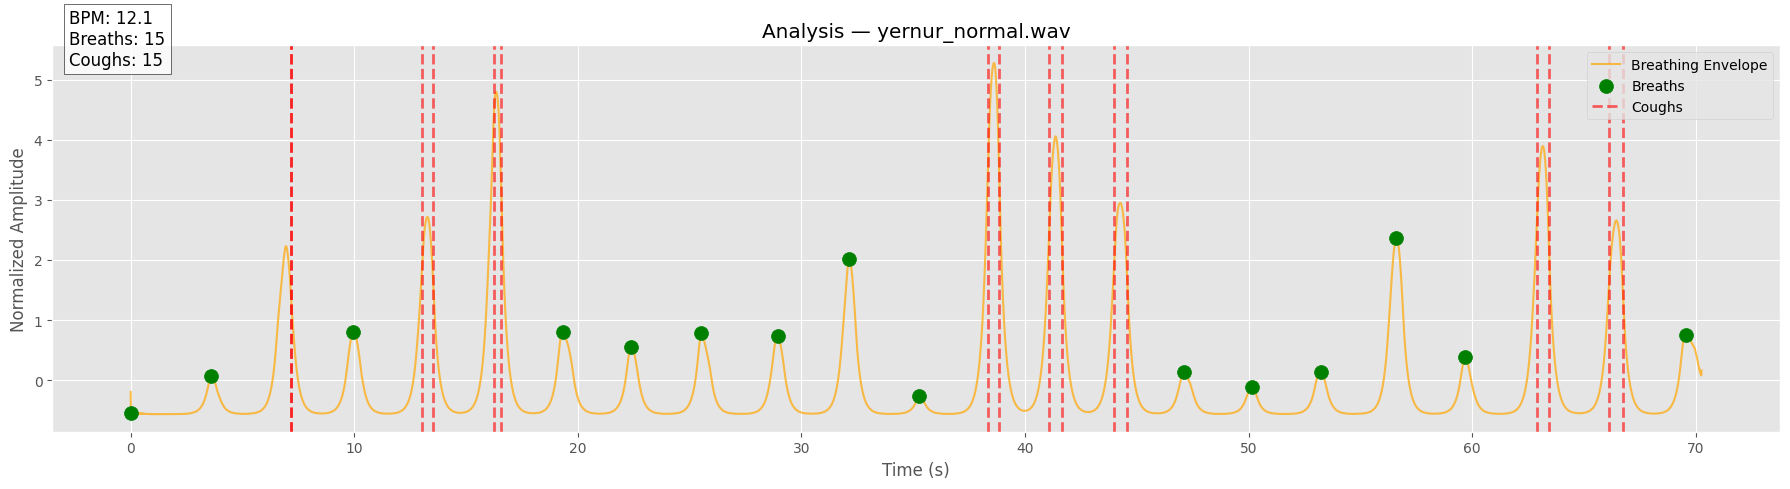

✓ yernur_normal.wav: 15 breaths, 15 coughs


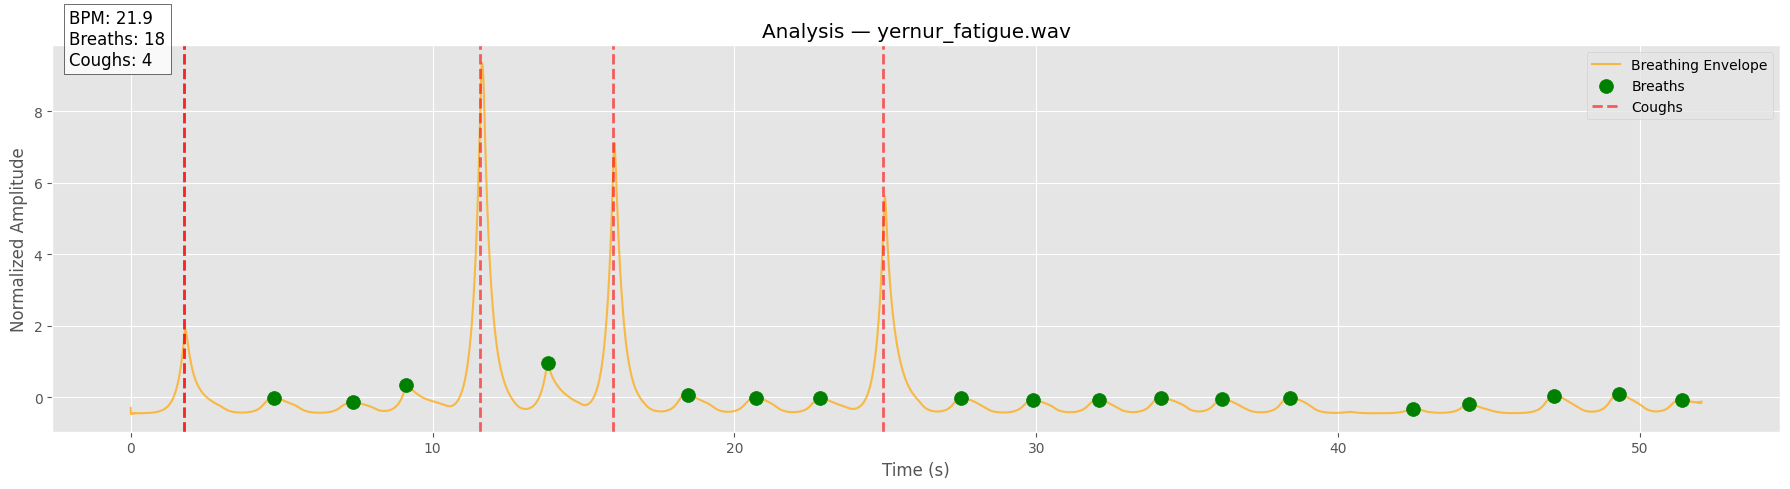

✓ yernur_fatigue.wav: 18 breaths, 4 coughs


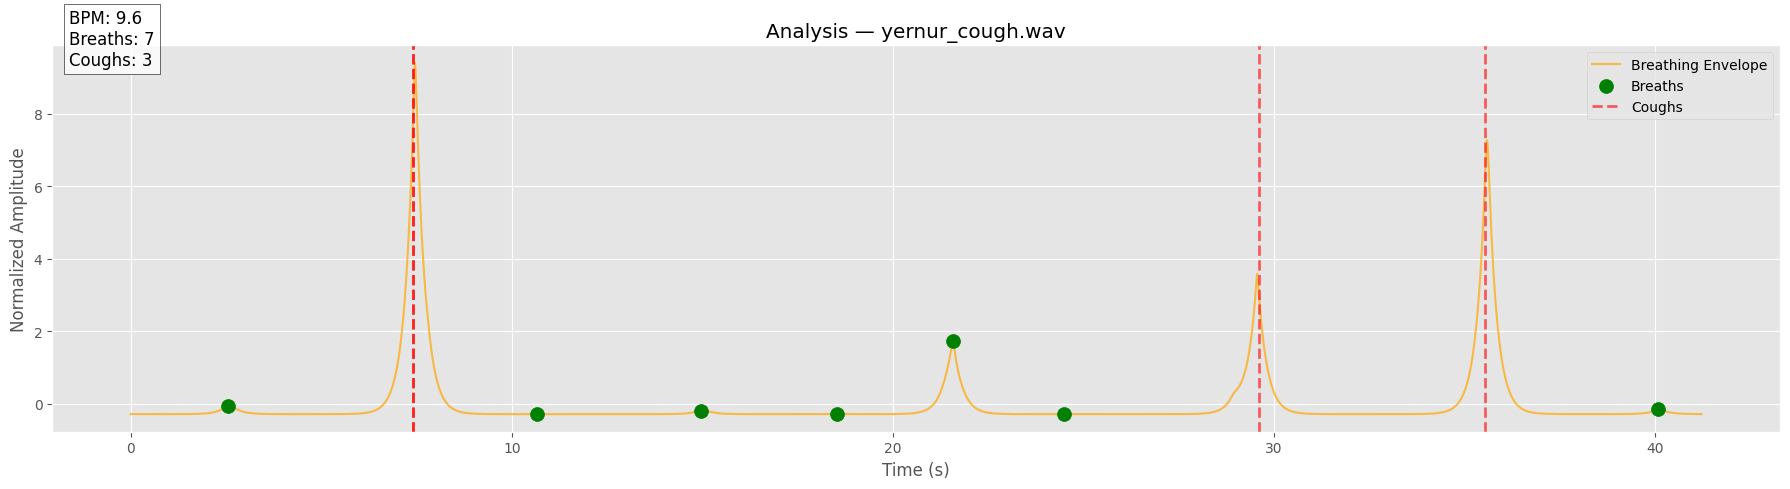

✓ yernur_cough.wav: 7 breaths, 3 coughs


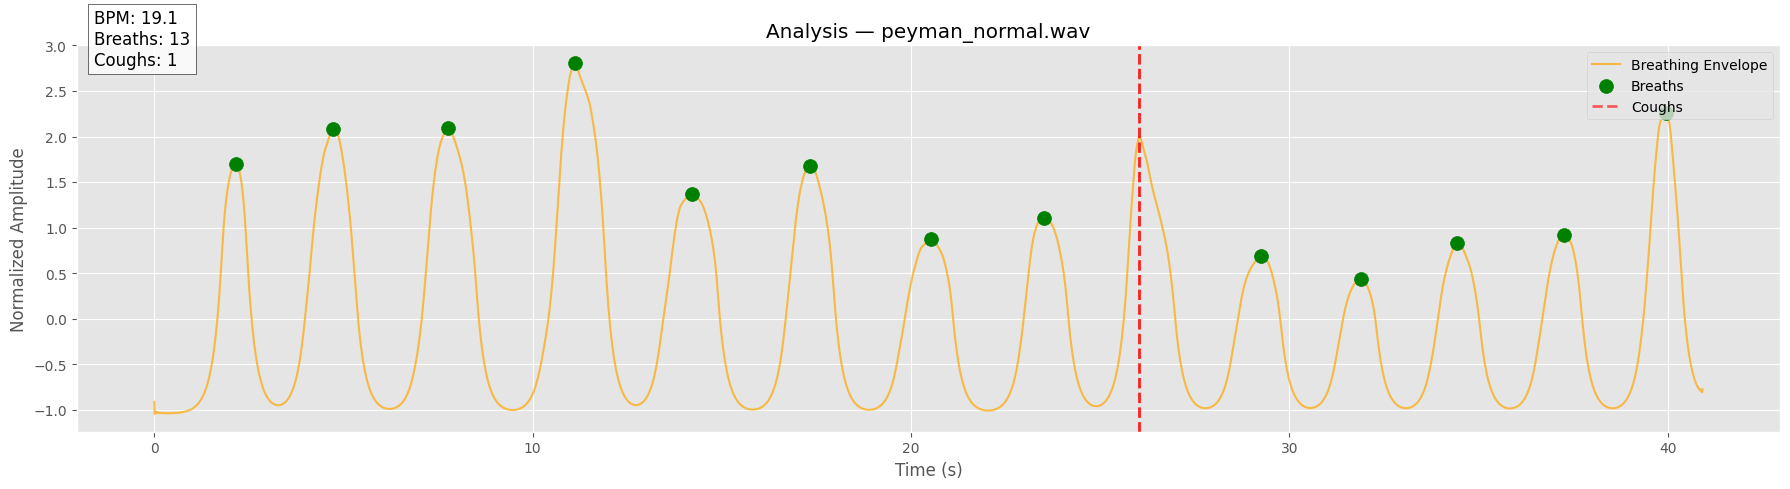

✓ peyman_normal.wav: 13 breaths, 1 coughs


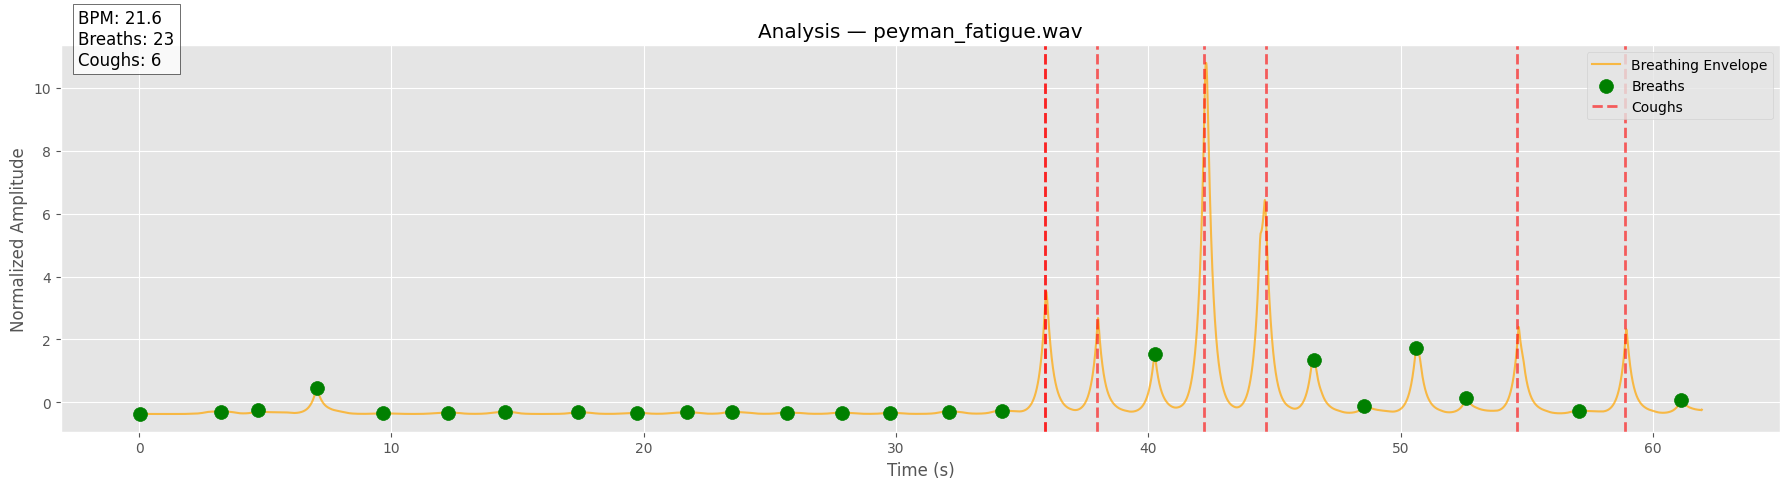

✓ peyman_fatigue.wav: 23 breaths, 6 coughs


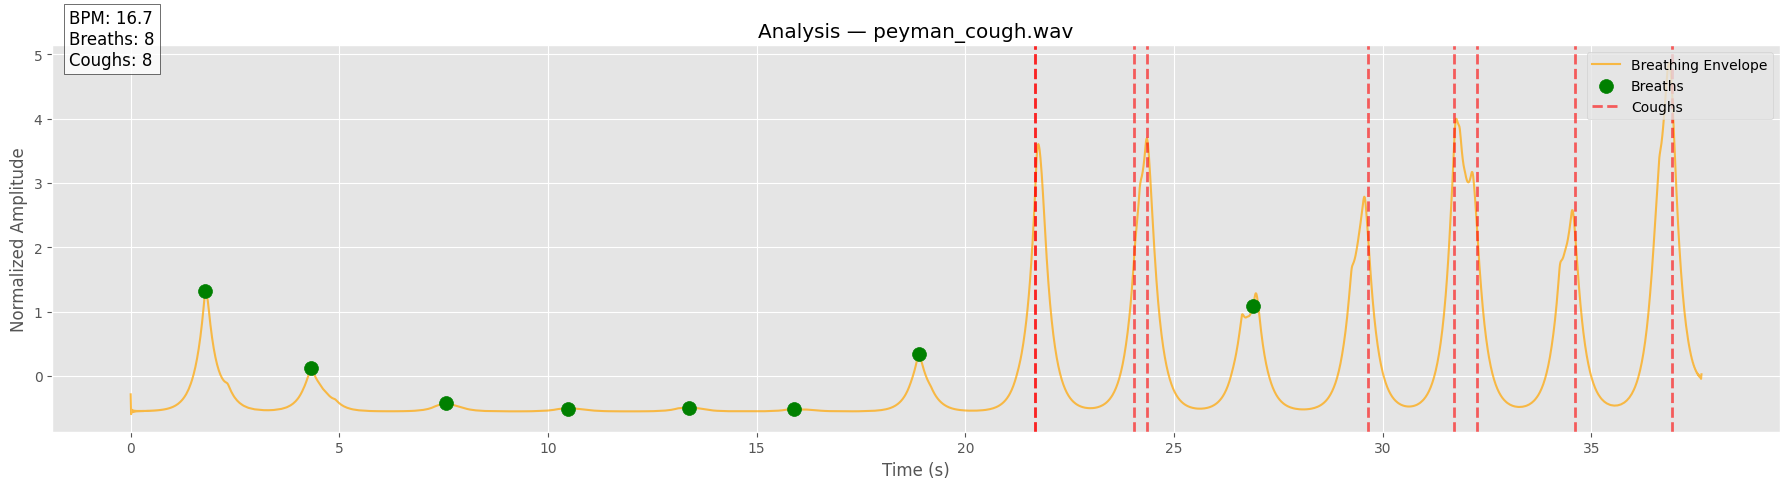

✓ peyman_cough.wav: 8 breaths, 8 coughs

COMPLETE RESULTS


,file,n_breaths,n_coughs,bpm,brv_sdnn,brv_rmssd,brv_cv,label,true_condition
0,emre_normal.wav,18,1,18.850490,0.299328,0.426255,0.094041,normal,normal
1,emre_fatigue.wav,25,4,23.762376,0.816114,1.147413,0.323213,fatigue,fatigue
2,emre_cough.wav,2,13,3.260870,0.000000,0.000000,0.000000,normal,cough
3,olena_normal.wav,22,0,18.231804,0.290236,0.319186,0.088192,normal,normal
4,olena_fatigue.wav,25,3,24.733768,0.977403,1.504047,0.402914,fatigue,fatigue
5,olena_cough.wav,3,12,2.625821,21.220000,42.440000,0.928665,normal,cough
6,narmeen_normal.wav,6,1,9.487666,2.577057,3.115333,0.407504,normal,normal
7,narmeen_fatigue.wav,9,3,18.085908,1.536162,2.508921,0.463048,normal,fatigue
8,narmeen_cough.wav,6,4,8.860012,3.303304,6.313391,0.487789,normal,cough
9,sneha_normal.wav,18,1,17.558960,0.814405,1.163736,0.238335,normal,normal


In [162]:
participants = ["emre", "olena", "narmeen", "sneha", "paula", "yernur", "peyman"]
conditions = ["normal", "fatigue", "cough"]

results_complete = []

for p in participants:
    for cond in conditions:
        fname = get_file(p, cond)
        try:
            out = analyze_breathing_and_coughs(fname)
            out["participant"] = p
            out["true_condition"] = cond
            results_complete.append(out)
            print(f"✓ {fname}: {out['n_breaths']} breaths, {out['n_coughs']} coughs")
        except Exception as e:
            print(f"✗ Error processing {fname}: {e}")

df_complete = pd.DataFrame(results_complete)

# Display results
print("\n" + "="*80)
print("COMPLETE RESULTS")
print("="*80)
df_complete[["file", "n_breaths", "n_coughs", "bpm", "brv_sdnn", "brv_rmssd", "brv_cv", "label", "true_condition"]]